<a href="https://colab.research.google.com/github/sapisfun/learnGenAI/blob/main/Ch03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


My First GAN Model to generate fake line following Pattern matching
---



In [ ]:
import torch
from torch import nn
device="cuda" if torch.cuda.is_available() else "cpu"

Creating Training Data

In [ ]:
torch.manual_seed(0)
observations = 2048
train_data = torch.zeros((observations, 2))
train_data[:,0]=50*torch.rand(observations)
train_data[:,1]=1.08**train_data[:,0]

Visualization the relation between X and Y

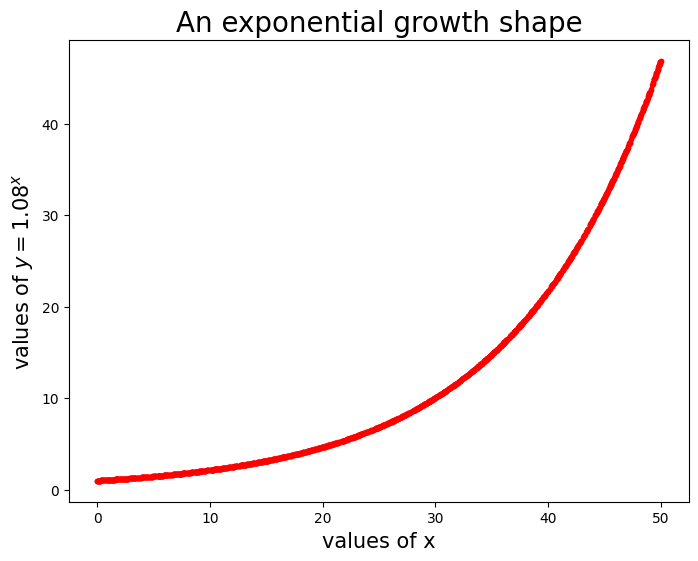

In [ ]:
import matplotlib.pyplot as plt
fig=plt.figure(dpi=100,figsize=(8,6))
plt.plot(train_data[:,0],train_data[:,1],".",c="r")
plt.xlabel("values of x",fontsize=15)
plt.ylabel("values of $y=1.08^x$",fontsize=15)
plt.title("An exponential growth shape",fontsize=20)
plt.show()

Preparing Training Dataset

In [ ]:
from torch.utils.data import DataLoader

batch_size=128
train_loader=DataLoader(
 train_data,
 batch_size=batch_size,
 shuffle=True)

In [ ]:
batch0=next(iter(train_loader))
print(batch0)

tensor([[41.9333, 25.2099],
        [ 8.0561,  1.8589],
        [22.2487,  5.5416],
        [49.9585, 46.7522],
        [ 8.7647,  1.9631],
        [ 3.0979,  1.2692],
        [26.0517,  7.4259],
        [38.2393, 18.9716],
        [37.1300, 17.4191],
        [45.0543, 32.0541],
        [ 8.7989,  1.9683],
        [20.4796,  4.8362],
        [46.7506, 36.5243],
        [21.8242,  5.3635],
        [11.2329,  2.3738],
        [40.3307, 22.2845],
        [47.0477, 37.3691],
        [47.6369, 39.1026],
        [16.2331,  3.4880],
        [11.7535,  2.4709],
        [12.8855,  2.6958],
        [20.6749,  4.9095],
        [ 4.6602,  1.4314],
        [26.3385,  7.5916],
        [31.7039, 11.4727],
        [45.5565, 33.3172],
        [41.3369, 24.0788],
        [26.8584,  7.9015],
        [14.9879,  3.1692],
        [33.7039, 13.3817],
        [47.7350, 39.3988],
        [31.7714, 11.5324],
        [ 7.4853,  1.7790],
        [14.5973,  3.0754],
        [31.4056, 11.2122],
        [35.8166, 15

Discriminator NN

In [ ]:
D=nn.Sequential(
 nn.Linear(2,256),
 nn.ReLU(),
 nn.Dropout(0.3),
 nn.Linear(256,128),
 nn.ReLU(),
 nn.Dropout(0.3),
 nn.Linear(128,64),
 nn.ReLU(),
 nn.Dropout(0.3),
 nn.Linear(64,1),
 nn.Sigmoid()).to(device)

Geneator NN

In [ ]:
G=nn.Sequential(
 nn.Linear(2,16),
 nn.ReLU(),
 nn.Linear(16,32),
 nn.ReLU(),
 nn.Linear(32,2)).to(device)

Setting Up Hyperparamters

In [ ]:
loss_fn=nn.BCELoss()
lr=0.0005
optimD=torch.optim.Adam(D.parameters(),lr=lr)
optimG=torch.optim.Adam(G.parameters(),lr=lr)

Instantiate the loss function

In [ ]:
mse=nn.MSELoss()

def performance(fake_samples):
  real=1.08**fake_samples[:,0]
  mseloss=mse(fake_samples[:,1],real)
  return mseloss

Earlystop function

In [ ]:
class EarlyStop:
  def __init__(self, patience=1000):
    self.patience = patience
    self.steps = 0
    self.min_gdif = float('inf')
  def stop(self, gdif):
    if gdif < self.min_gdif:
      self.min_gdif = gdif
      self.steps = 0
    elif gdif >= self.min_gdif:
      self.steps += 1
    if self.steps >= self.patience:
       return True
    else:
        return False
stopper=EarlyStop()

The training of GANs

In [ ]:
real_labels=torch.ones((batch_size,1))
real_labels=real_labels.to(device)

fake_labels=torch.zeros((batch_size,1))
fake_labels=fake_labels.to(device)

In [ ]:
def train_D_on_real(real_samples):
  real_samples=real_samples.to(device)
  optimD.zero_grad()
  out_D=D(real_samples)
  loss_D=loss_fn(out_D,real_labels)
  loss_D.backward()
  optimD.step()
  return loss_D

In [ ]:
def train_D_on_fake():
  noise=torch.randn((batch_size,2))
  noise=noise.to(device)
  fake_samples=G(noise)
  optimD.zero_grad()
  out_D=D(fake_samples)
  loss_D=loss_fn(out_D,fake_labels)
  loss_D.backward()
  optimD.step()
  return loss_D

In [ ]:
def train_G():
  noise=torch.randn((batch_size,2))
  noise=noise.to(device)
  optimG.zero_grad()
  fake_samples=G(noise)
  out_G=D(fake_samples)
  loss_G=loss_fn(out_G,real_labels)
  loss_G.backward()
  optimG.step()
  return loss_G, fake_samples

In [ ]:
import os
os.makedirs("files", exist_ok=True)    #A

def test_epoch(epoch,gloss,dloss,n,fake_samples):
    if epoch==0 or (epoch+1)%25==0:
        g=gloss.item()/n
        d=dloss.item()/n
        print(f"at epoch {epoch+1}, G loss: {g}, D loss {d}")    #B
        fake=fake_samples.detach().cpu().numpy()
        plt.figure(dpi=200)
        plt.plot(fake[:,0],fake[:,1],"*",c="g",
            label="generated samples")    #C
        plt.plot(train_data[:,0],train_data[:,1],".",c="r",
            alpha=0.1,label="real samples")    #D
        plt.title(f"epoch {epoch+1}")
        plt.xlim(0,50)
        plt.ylim(0,50)
        plt.legend()
        plt.savefig(f"files/p{epoch+1}.png")
        plt.show()

Final Training Process

at epoch 1, G loss: 0.7823835372924804, D loss 0.843374506632487


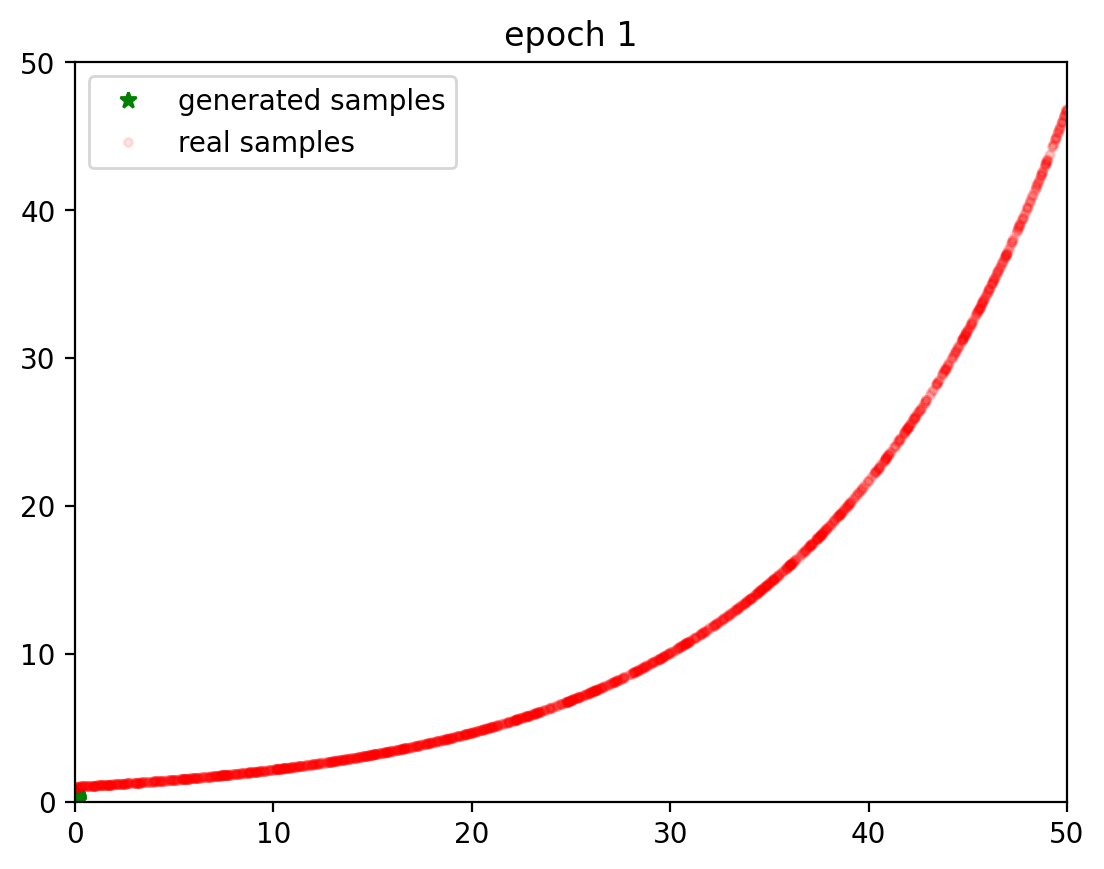

at epoch 25, G loss: 2.2677889506022137, D loss 0.5493166605631511


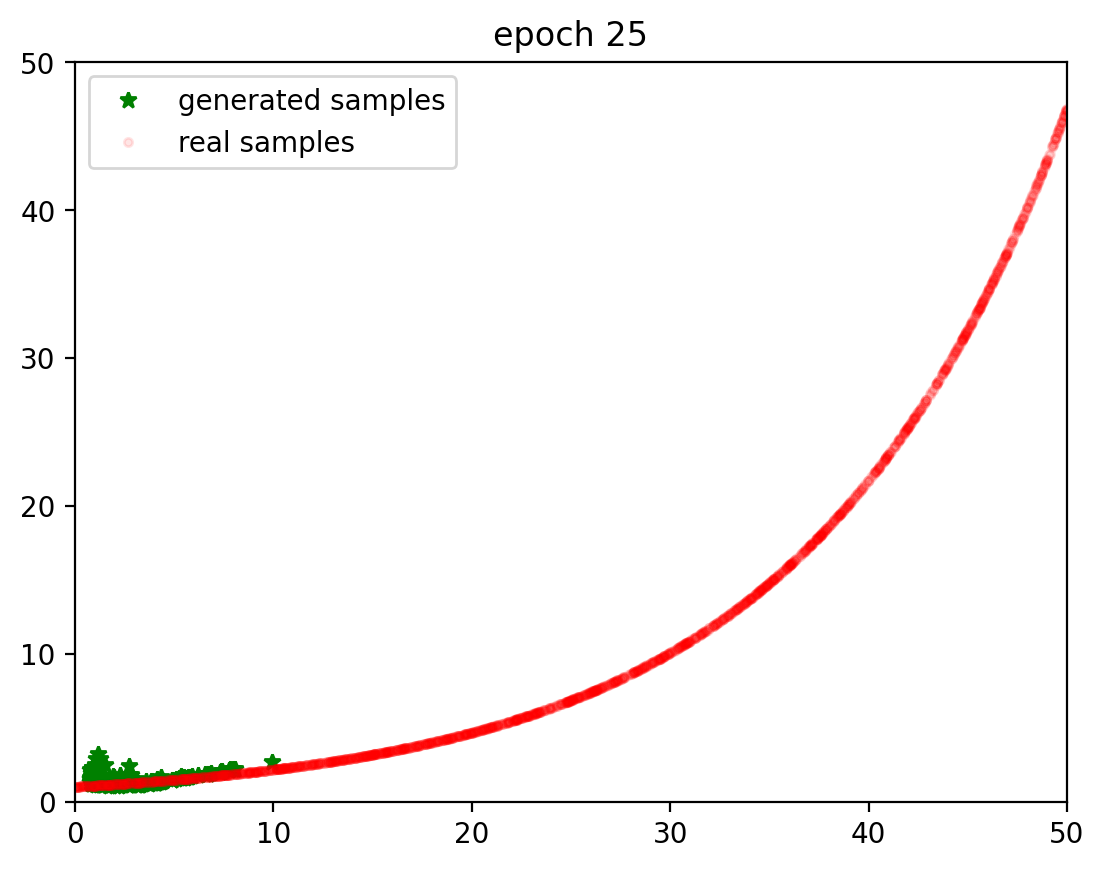

at epoch 50, G loss: 1.4454511006673176, D loss 0.9451562245686849


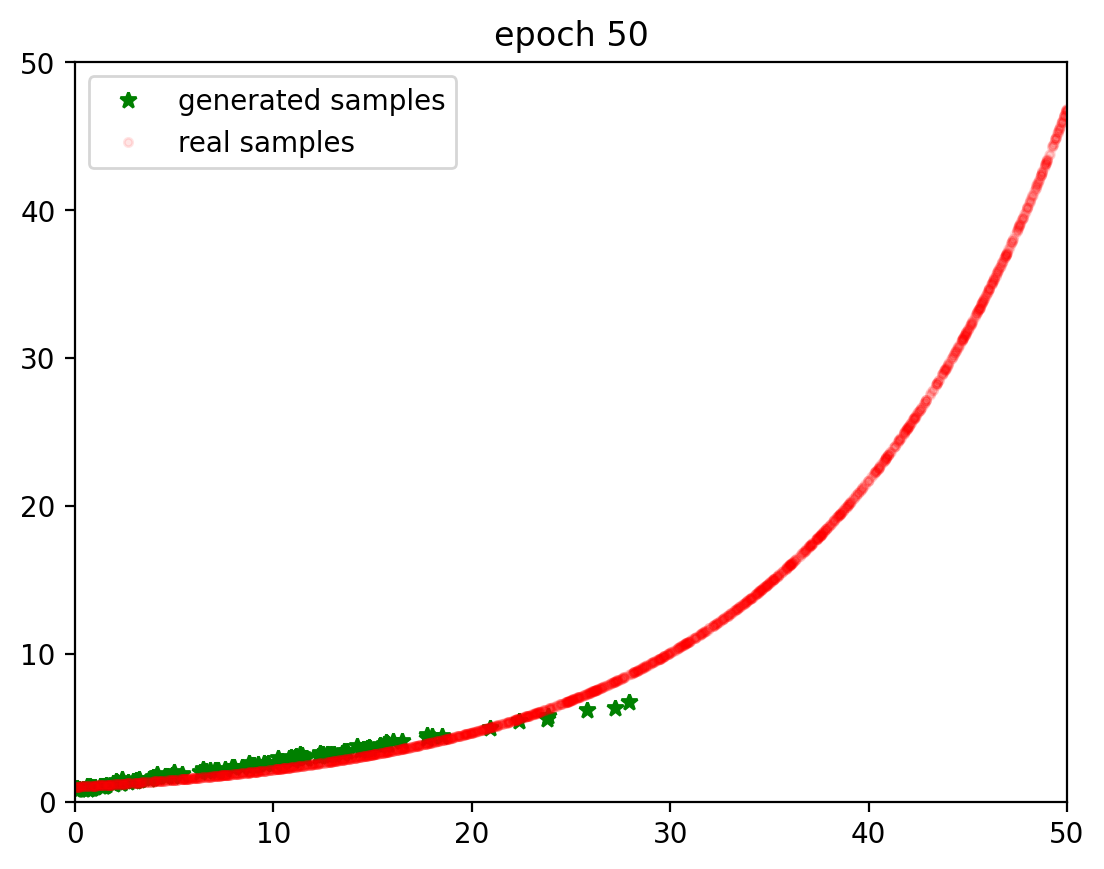

at epoch 75, G loss: 1.2453197479248046, D loss 1.0100873947143554


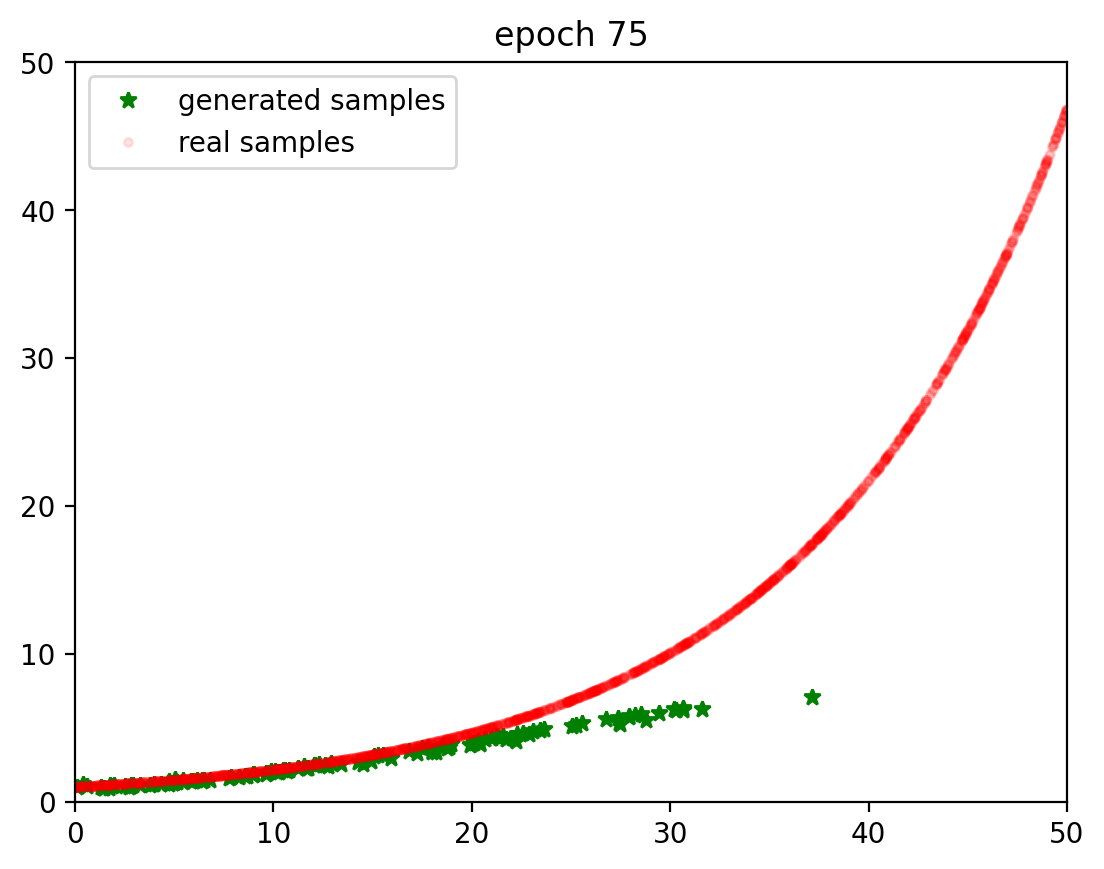

at epoch 100, G loss: 1.1121781667073567, D loss 1.0965660095214844


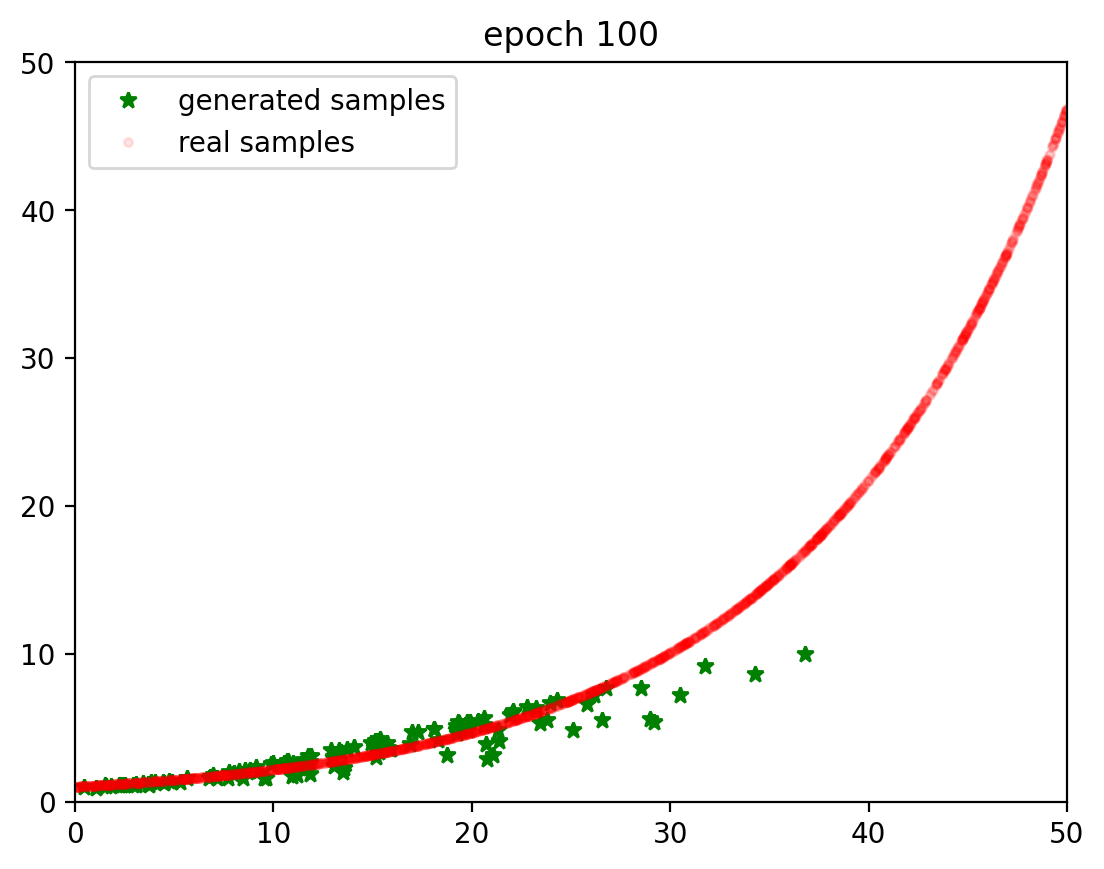

at epoch 125, G loss: 1.0815989176432292, D loss 1.116943105061849


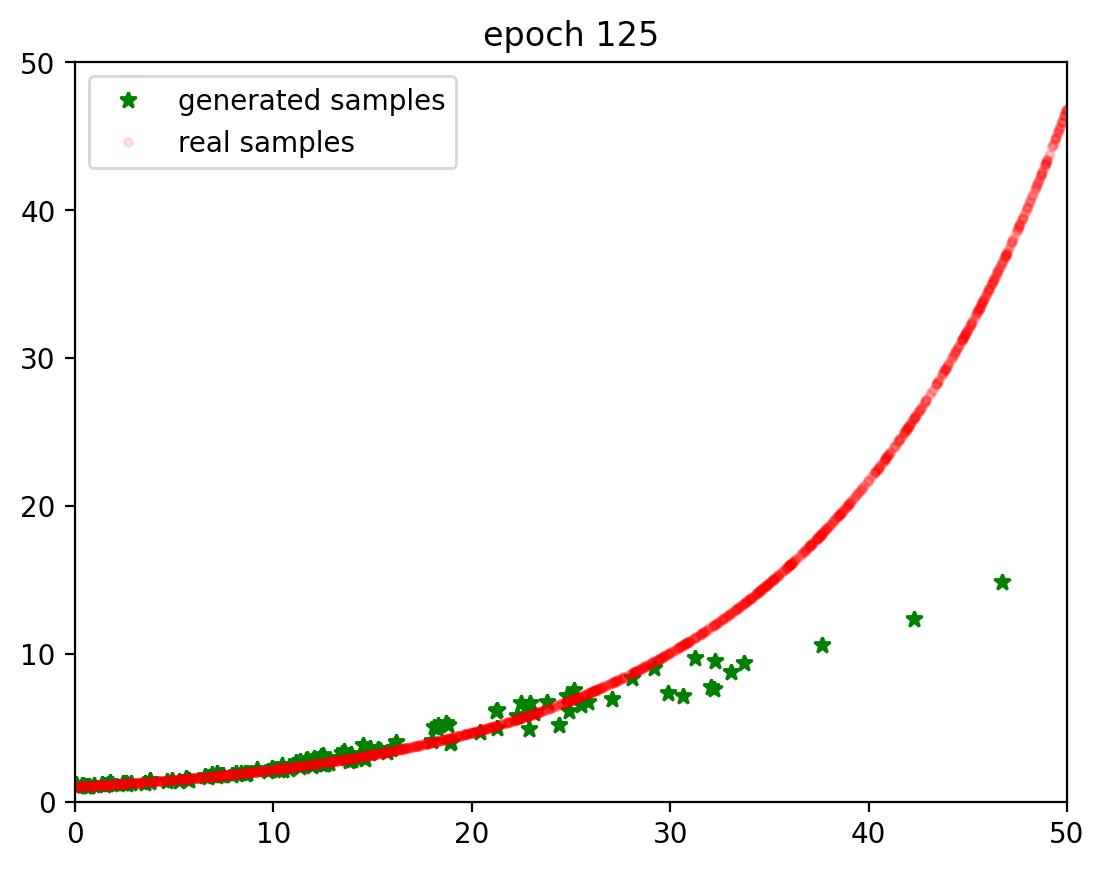

at epoch 150, G loss: 1.0165709177652995, D loss 1.174163818359375


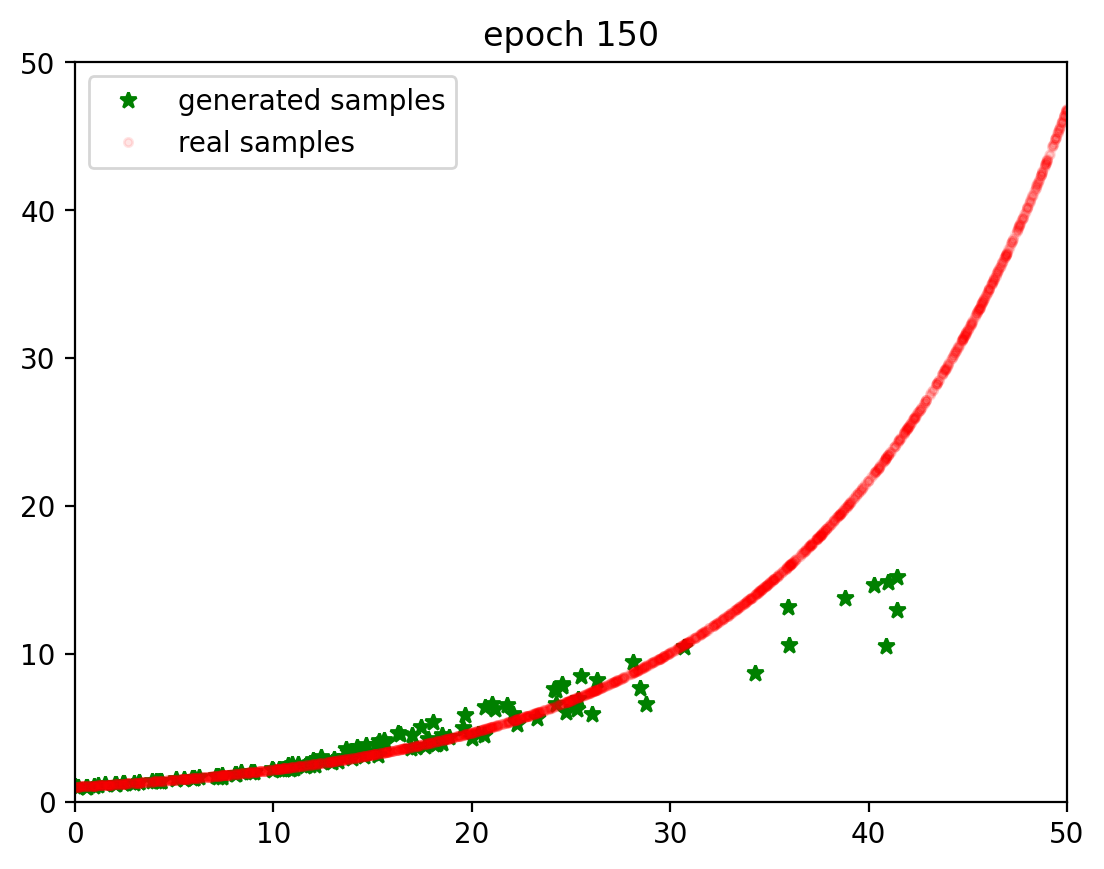

at epoch 175, G loss: 0.9590977986653646, D loss 1.2621971130371095


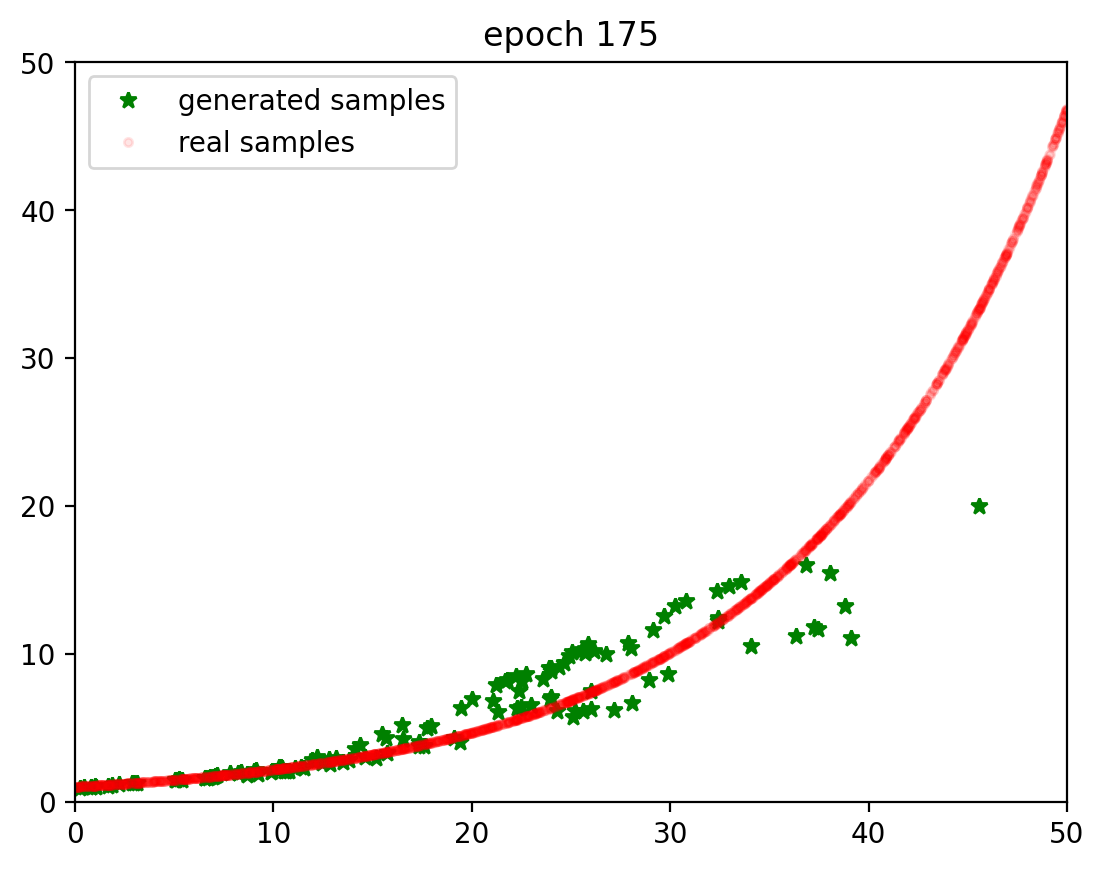

at epoch 200, G loss: 0.8872171401977539, D loss 1.3274557749430338


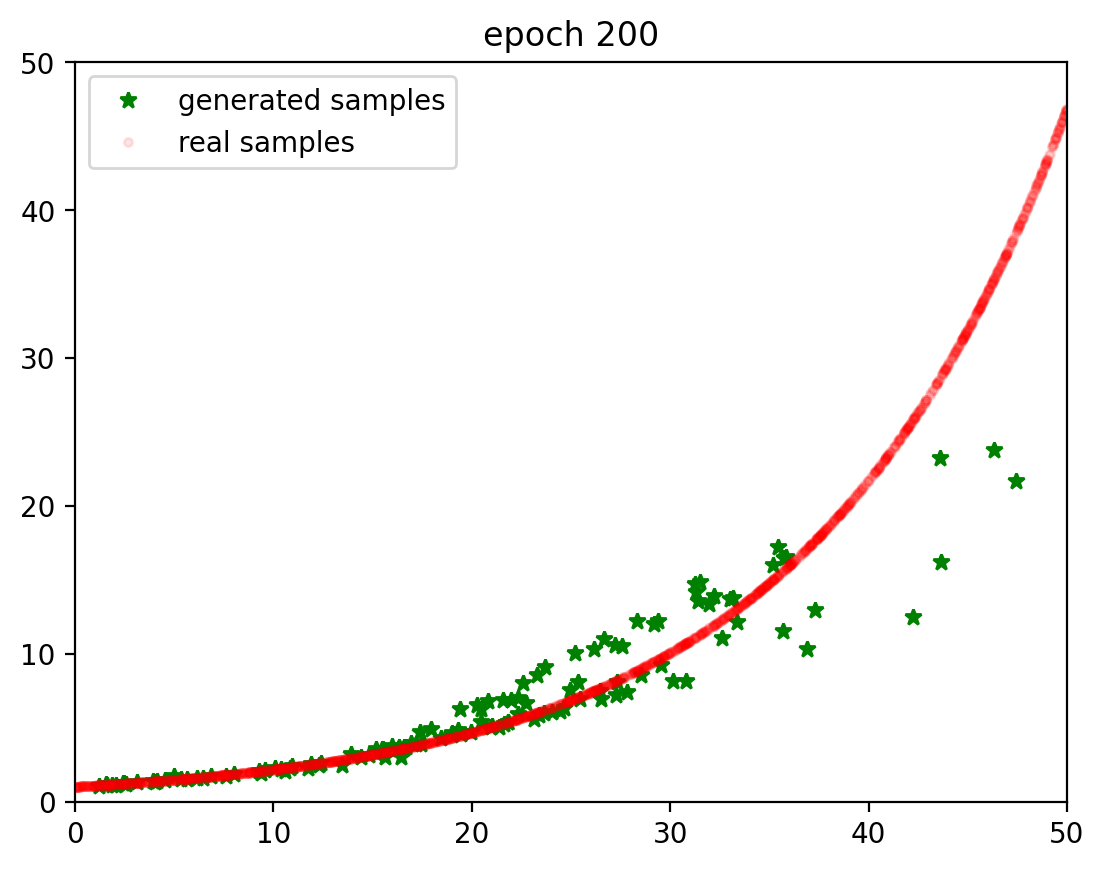

at epoch 225, G loss: 0.8496477127075195, D loss 1.3699261983235678


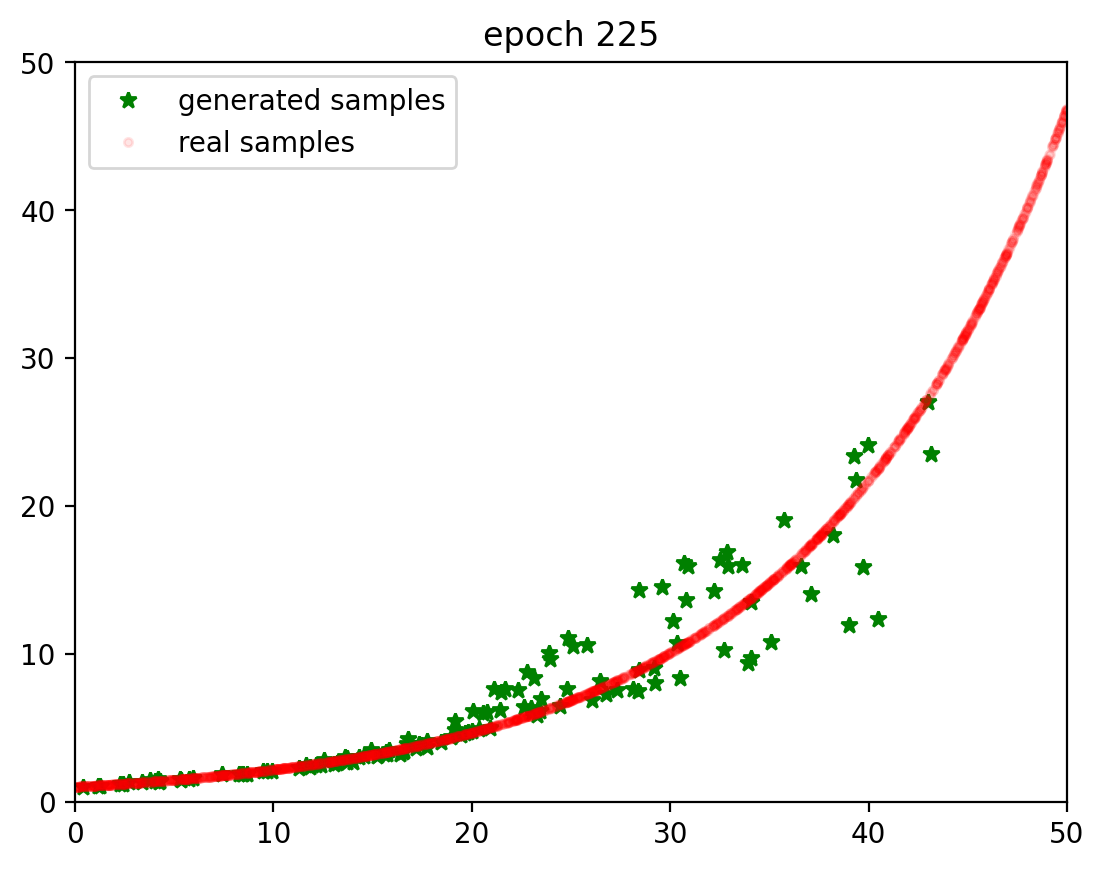

at epoch 250, G loss: 0.8127018610636393, D loss 1.4196300506591797


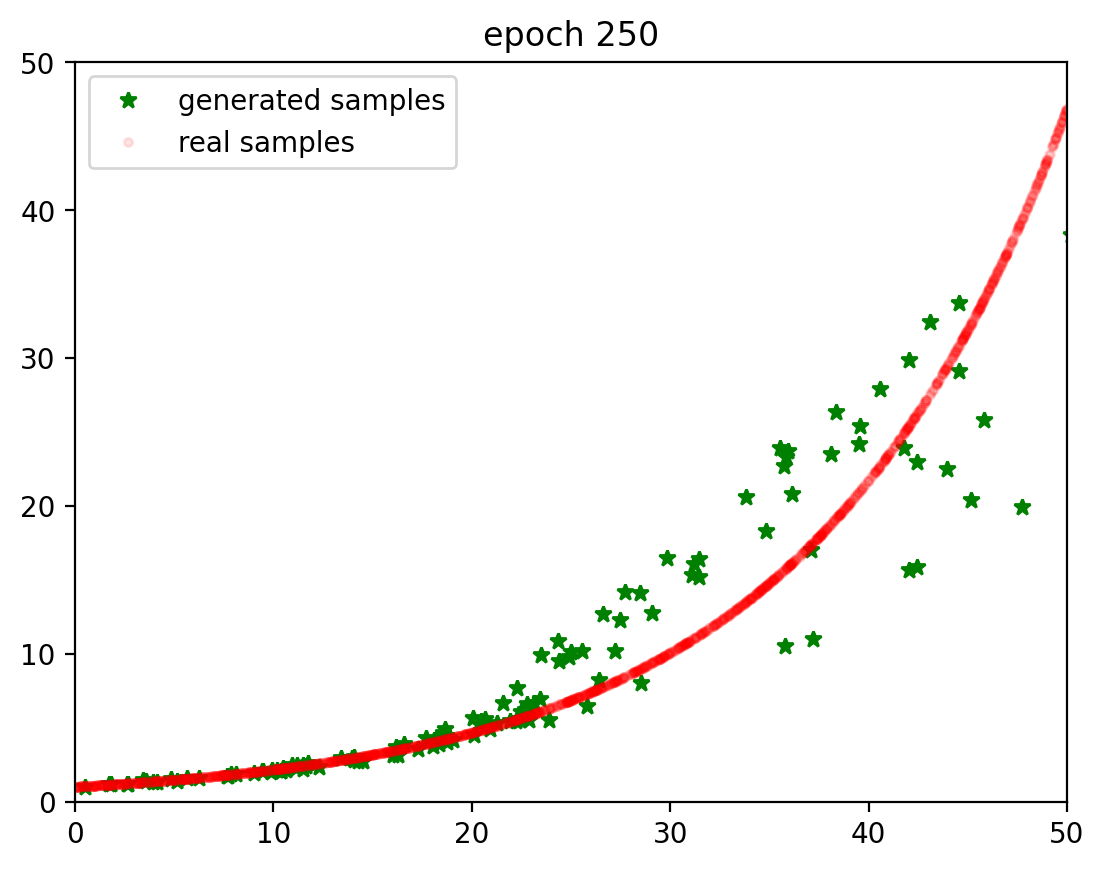

at epoch 275, G loss: 0.7896872838338216, D loss 1.4688232421875


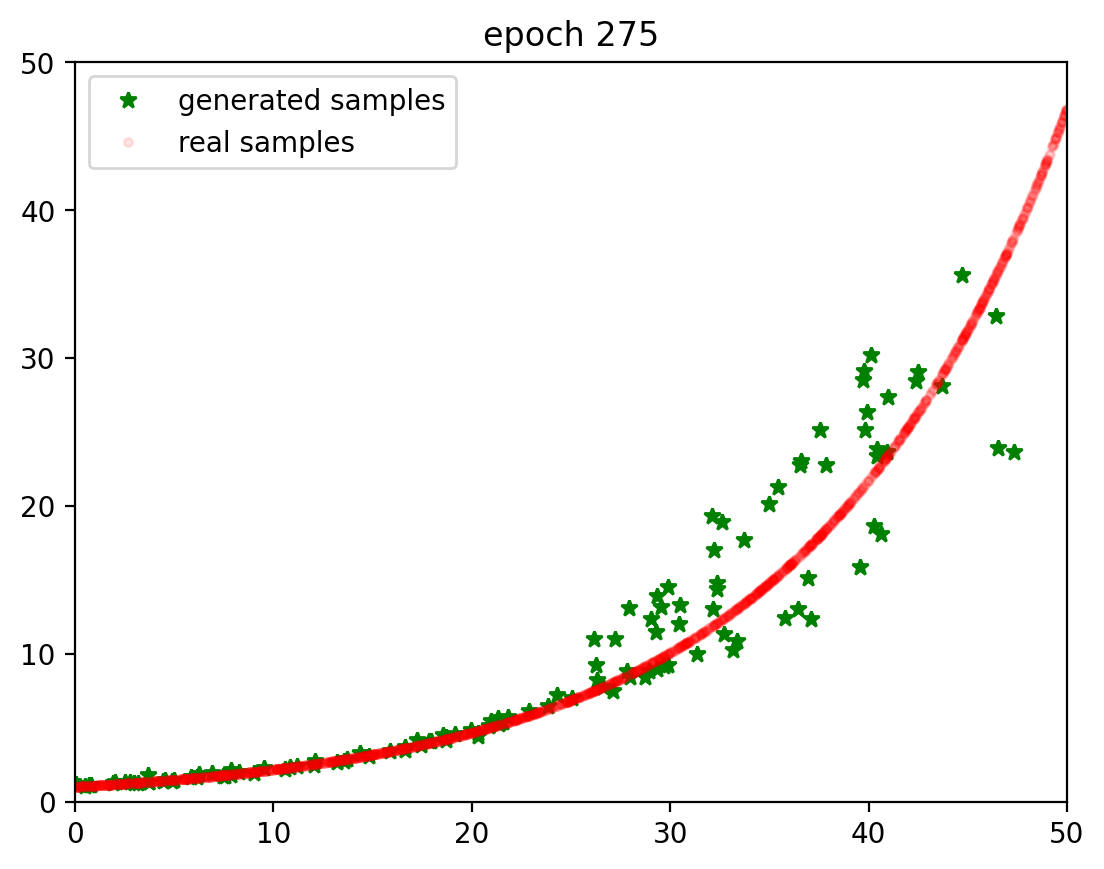

at epoch 300, G loss: 0.7783957799275716, D loss 1.4753602345784504


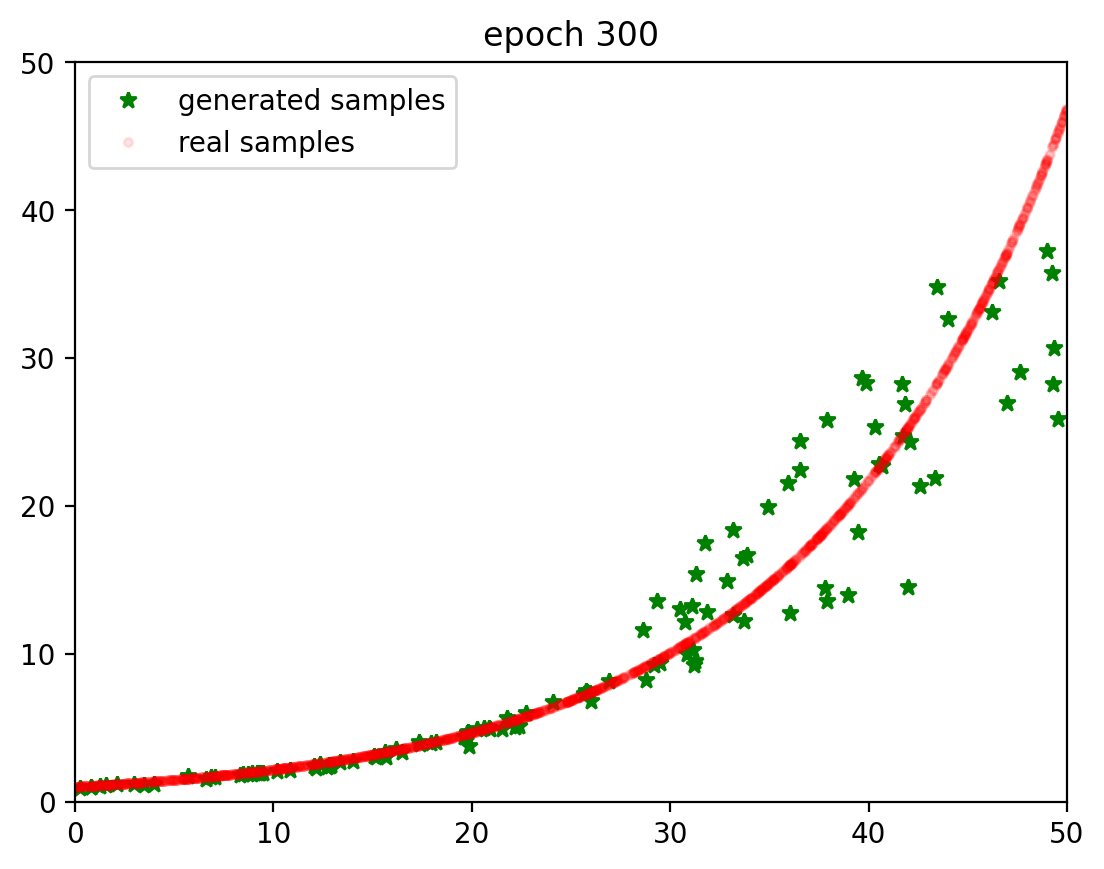

at epoch 325, G loss: 0.7742083231608073, D loss 1.4803209940592448


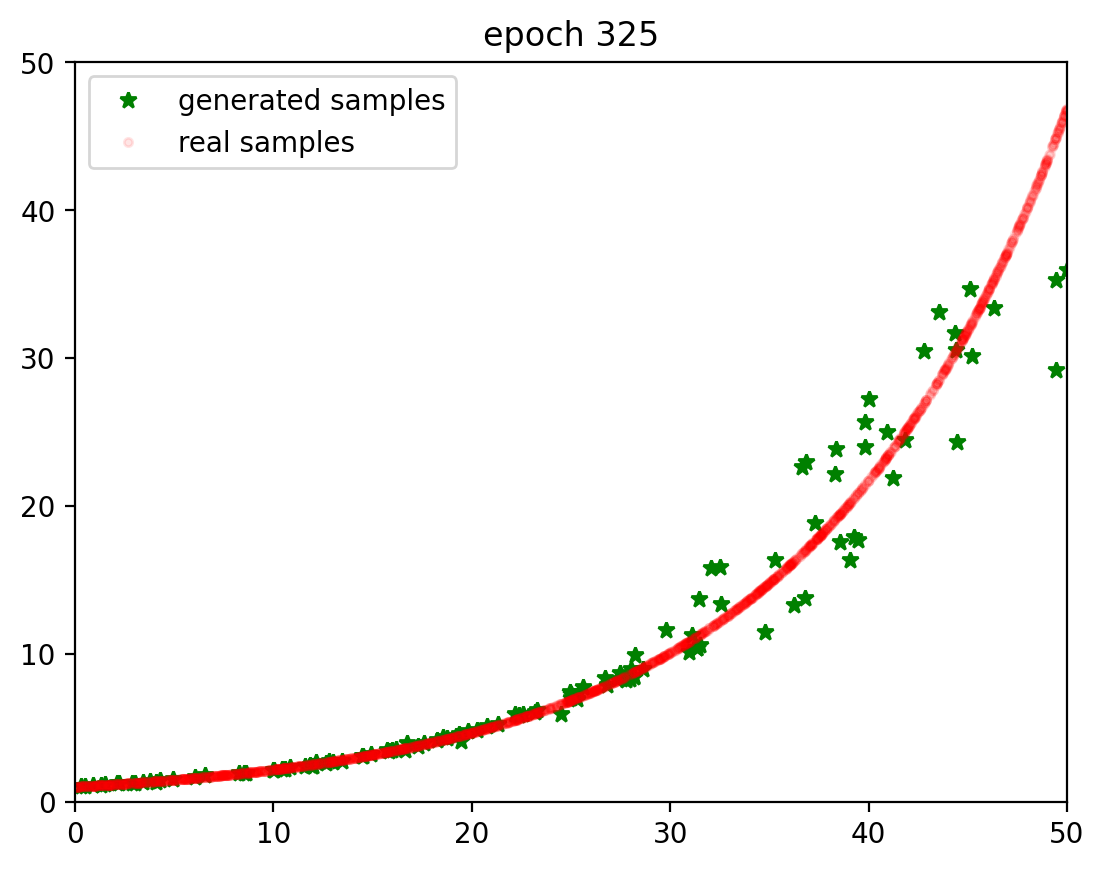

at epoch 350, G loss: 0.7635942459106445, D loss 1.4731168111165365


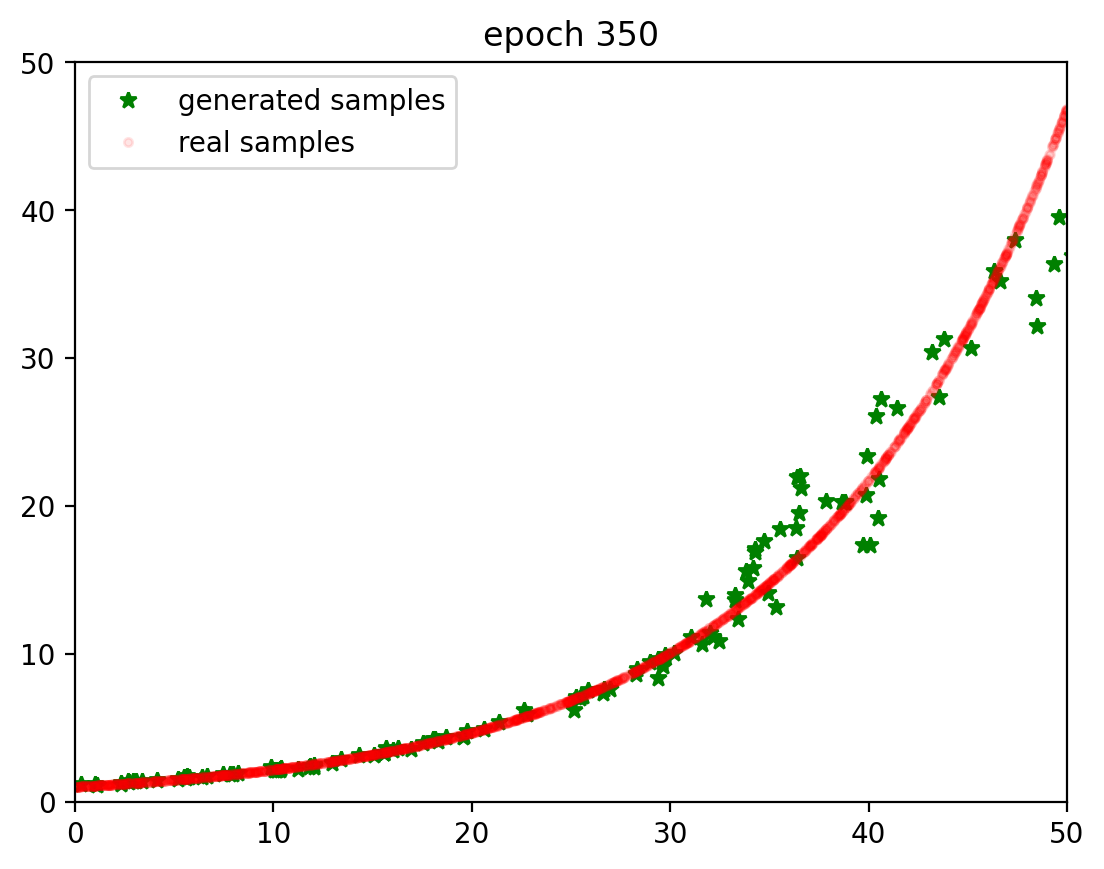

at epoch 375, G loss: 0.7672573089599609, D loss 1.4763425191243489


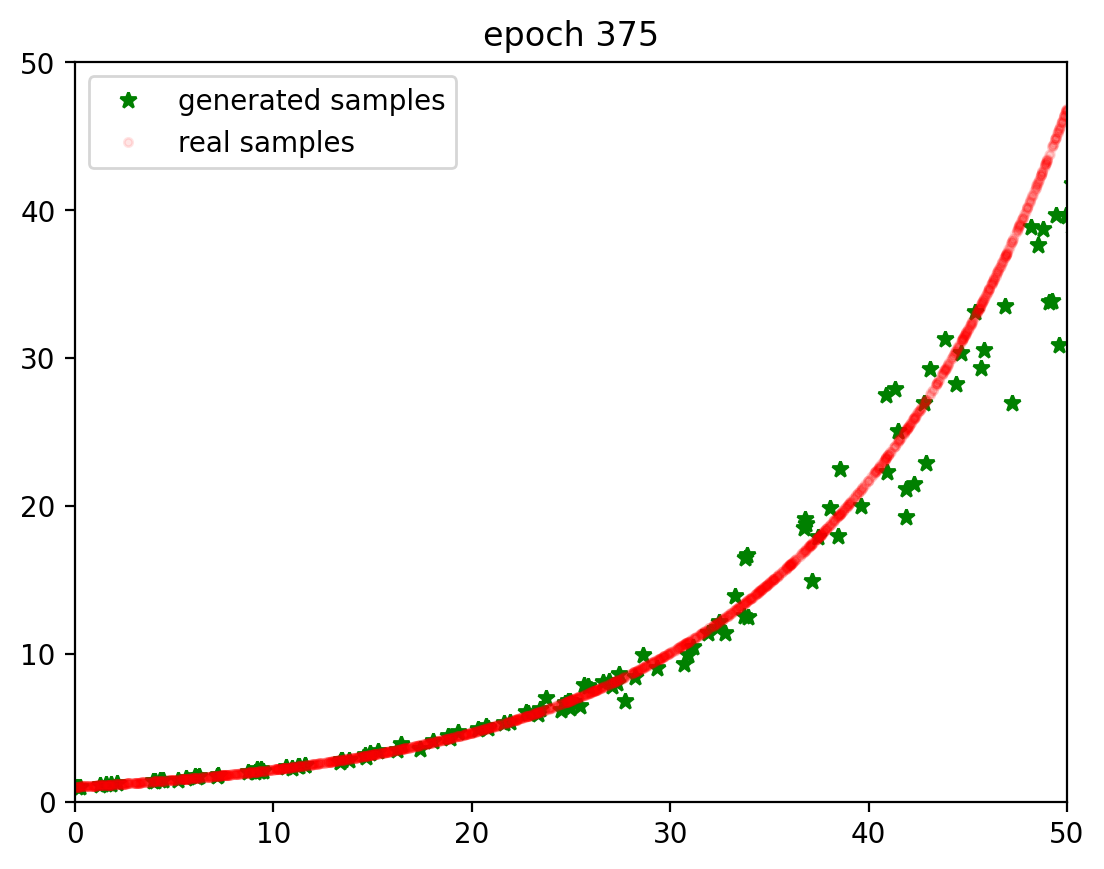

at epoch 400, G loss: 0.7695262273152669, D loss 1.468915303548177


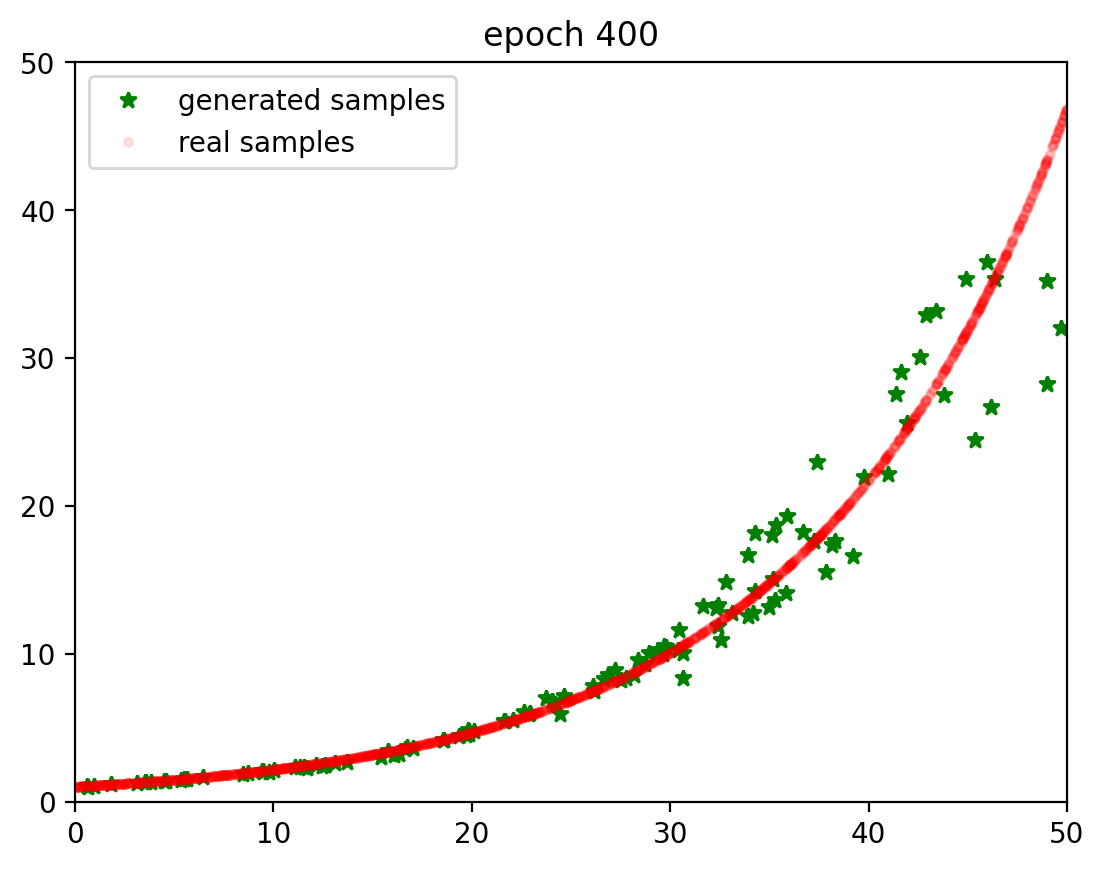

at epoch 425, G loss: 0.7636521021525066, D loss 1.4749693552652994


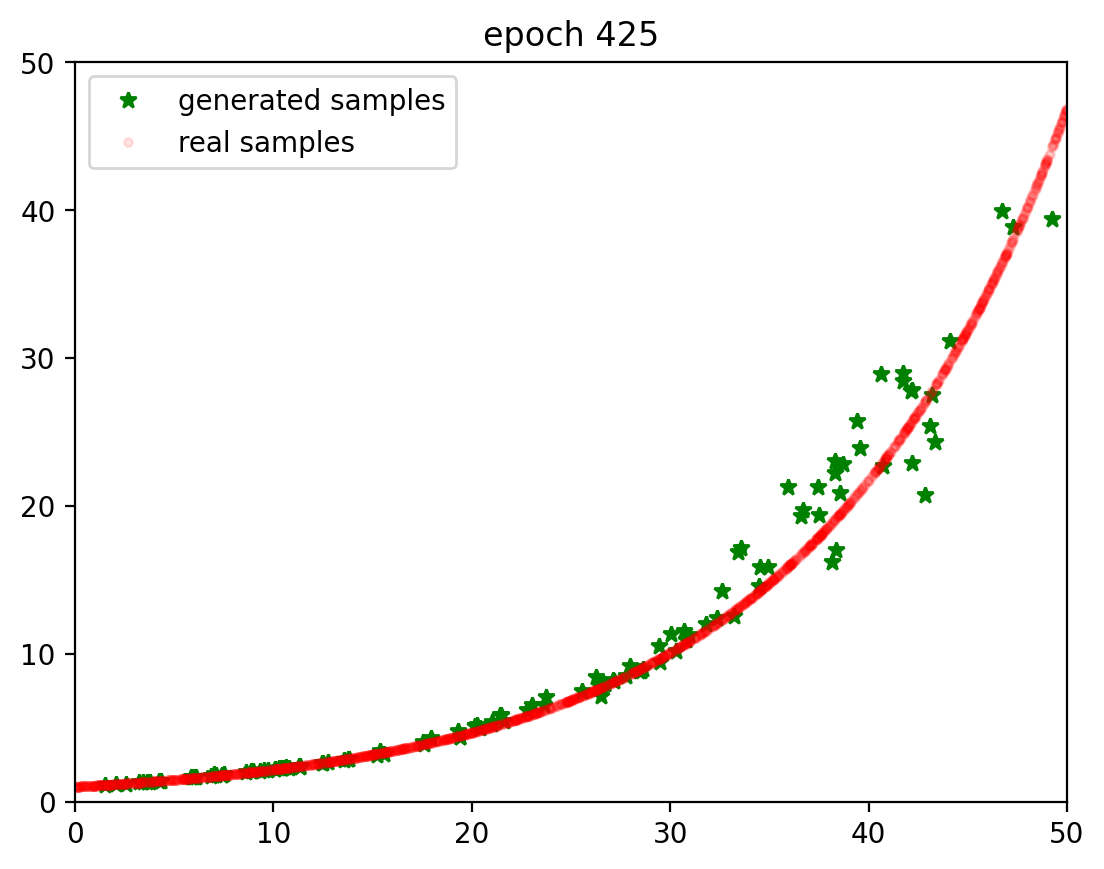

at epoch 450, G loss: 0.7752759297688802, D loss 1.479156494140625


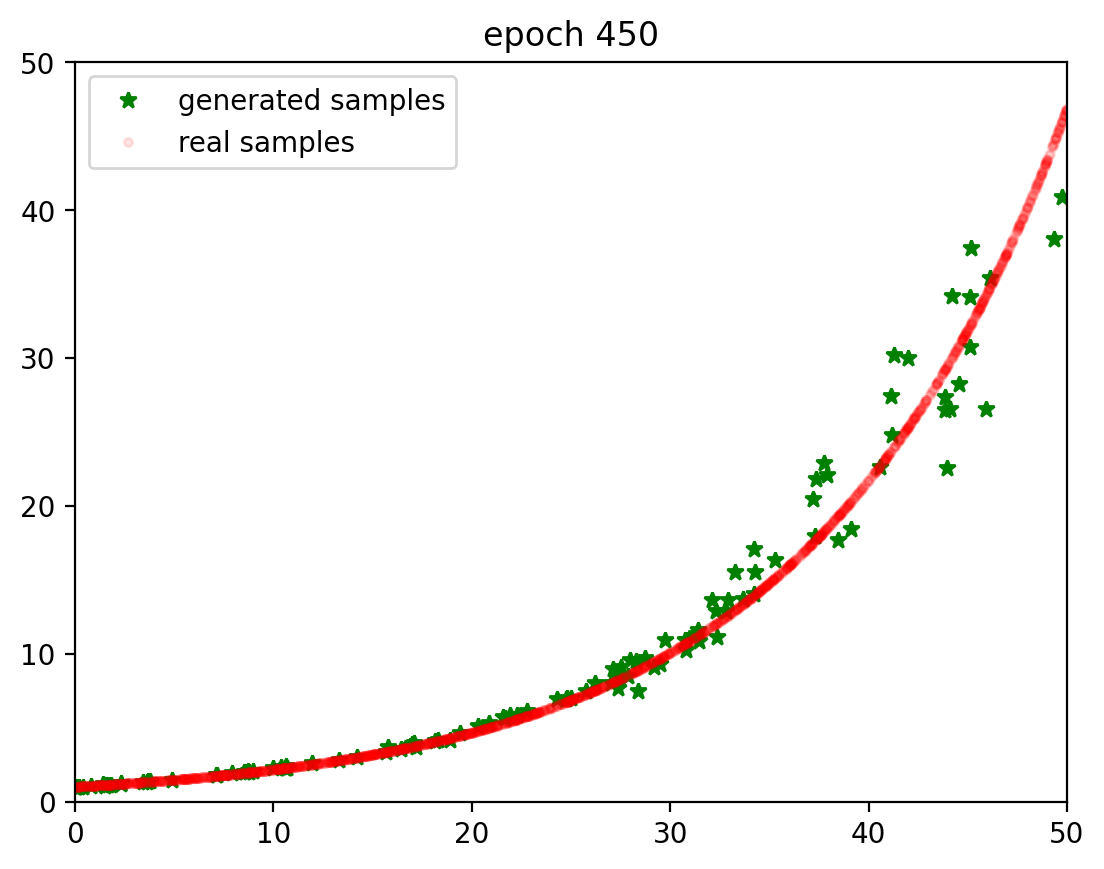

at epoch 475, G loss: 0.7579891204833984, D loss 1.4733117421468098


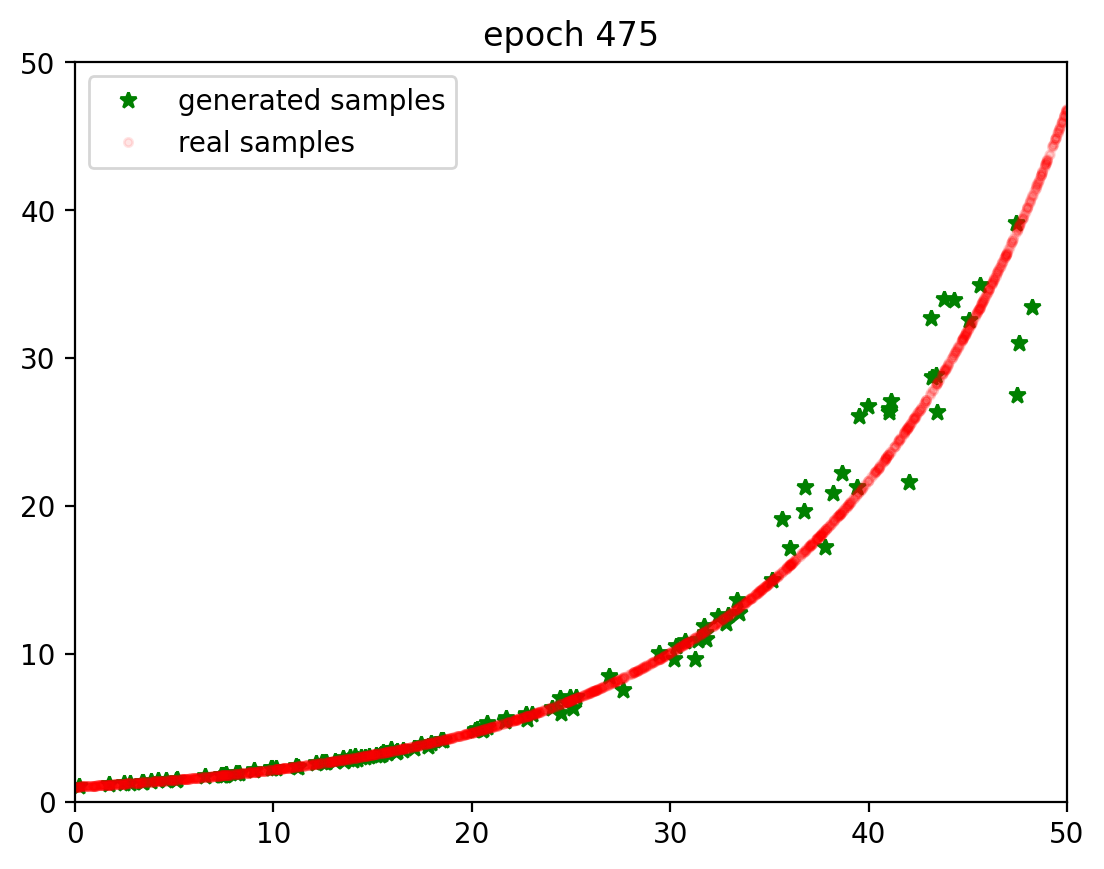

at epoch 500, G loss: 0.7625768661499024, D loss 1.469325637817383


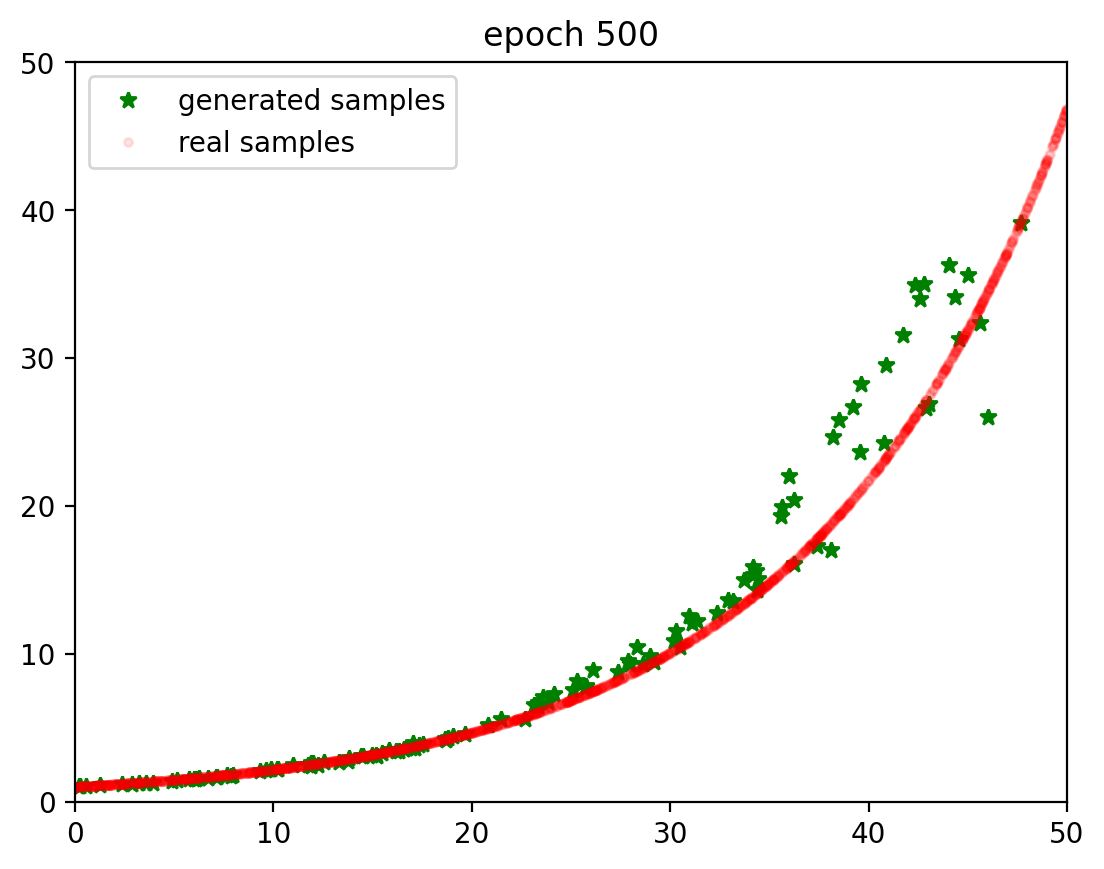

at epoch 525, G loss: 0.7588468551635742, D loss 1.4720367431640624


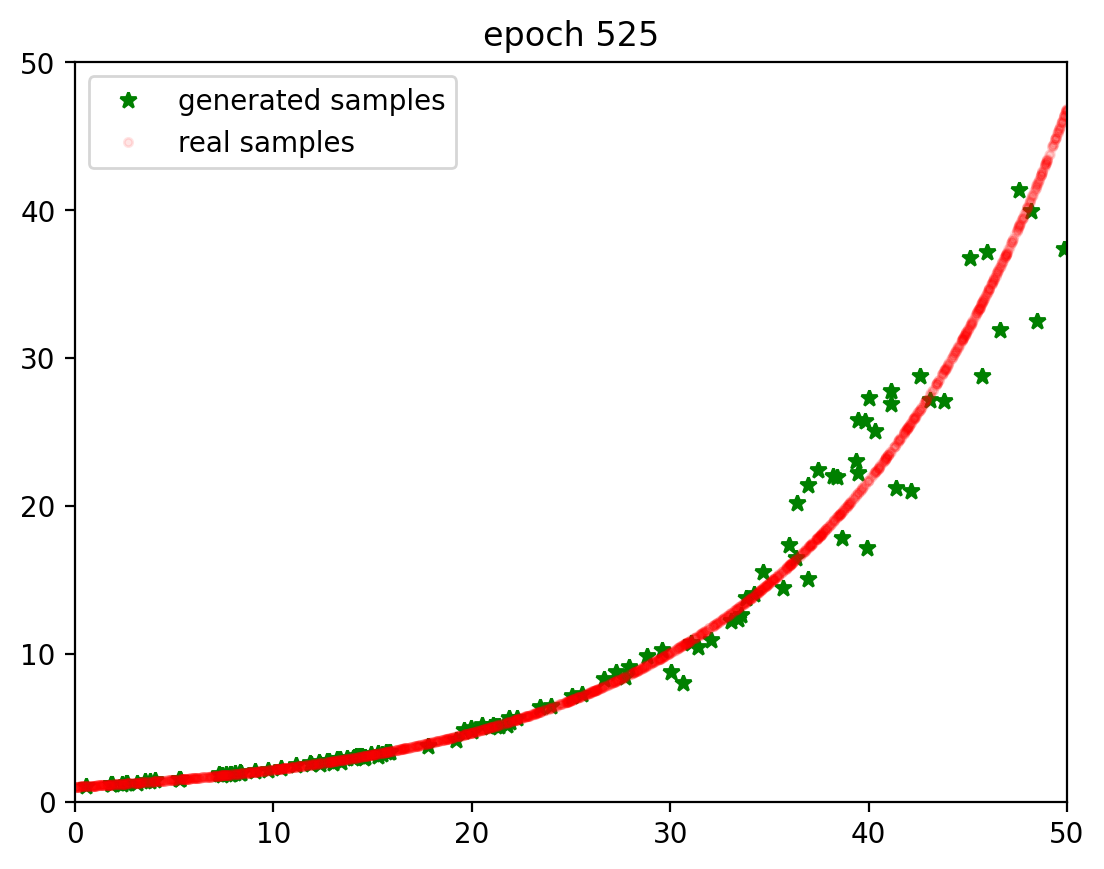

at epoch 550, G loss: 0.7526546478271484, D loss 1.4740416208902996


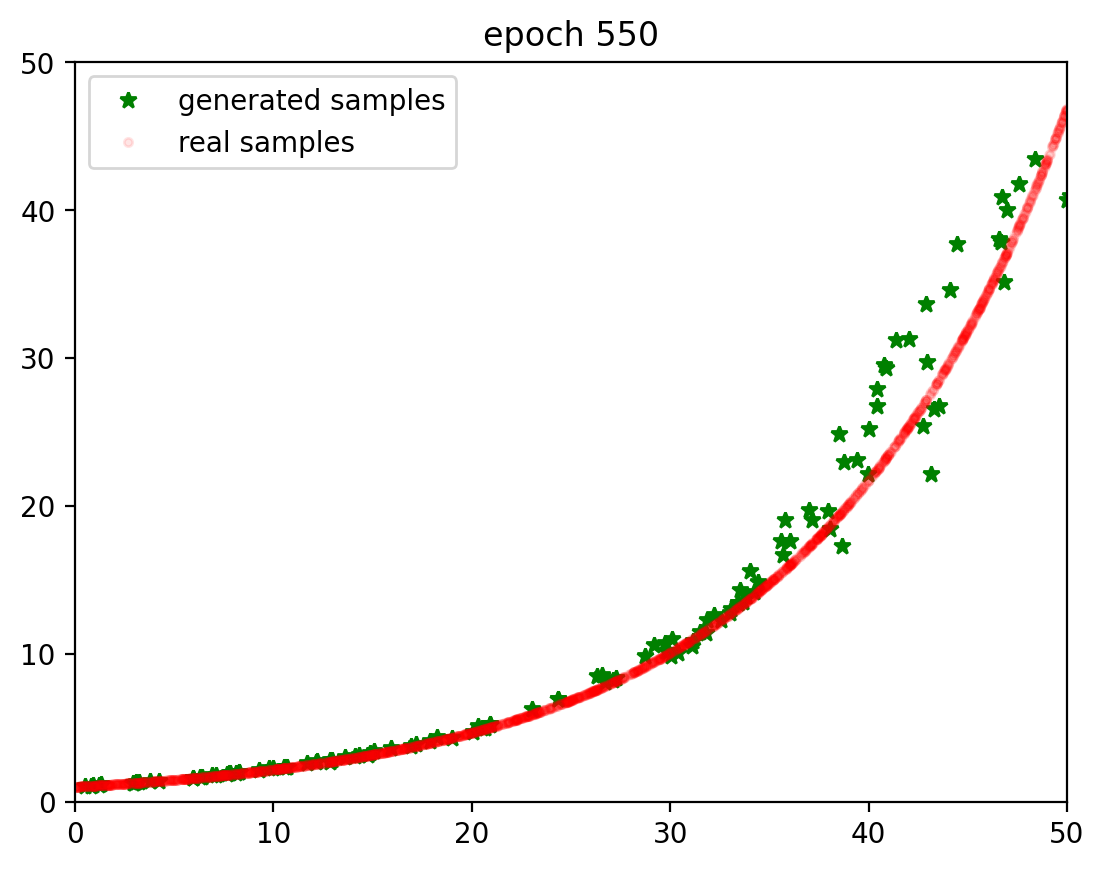

at epoch 575, G loss: 0.7620749155680339, D loss 1.4736254374186197


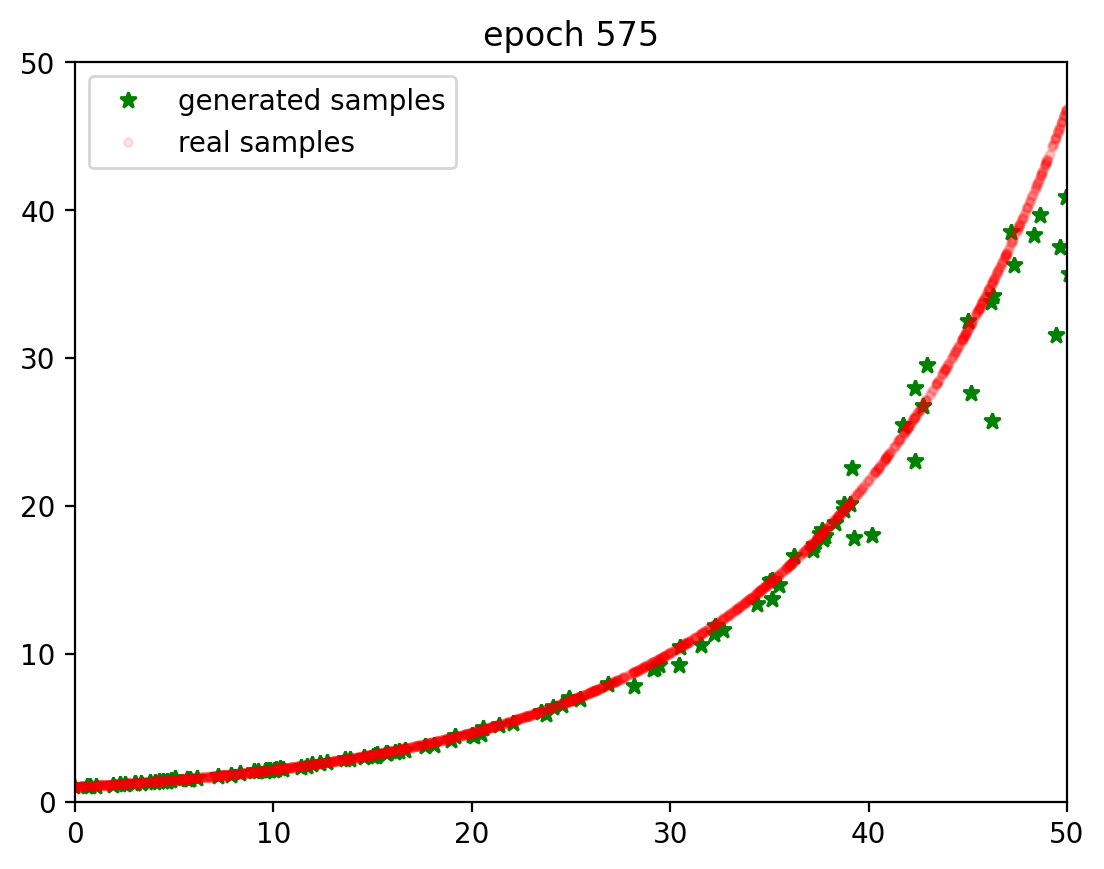

at epoch 600, G loss: 0.760158920288086, D loss 1.4720218658447266


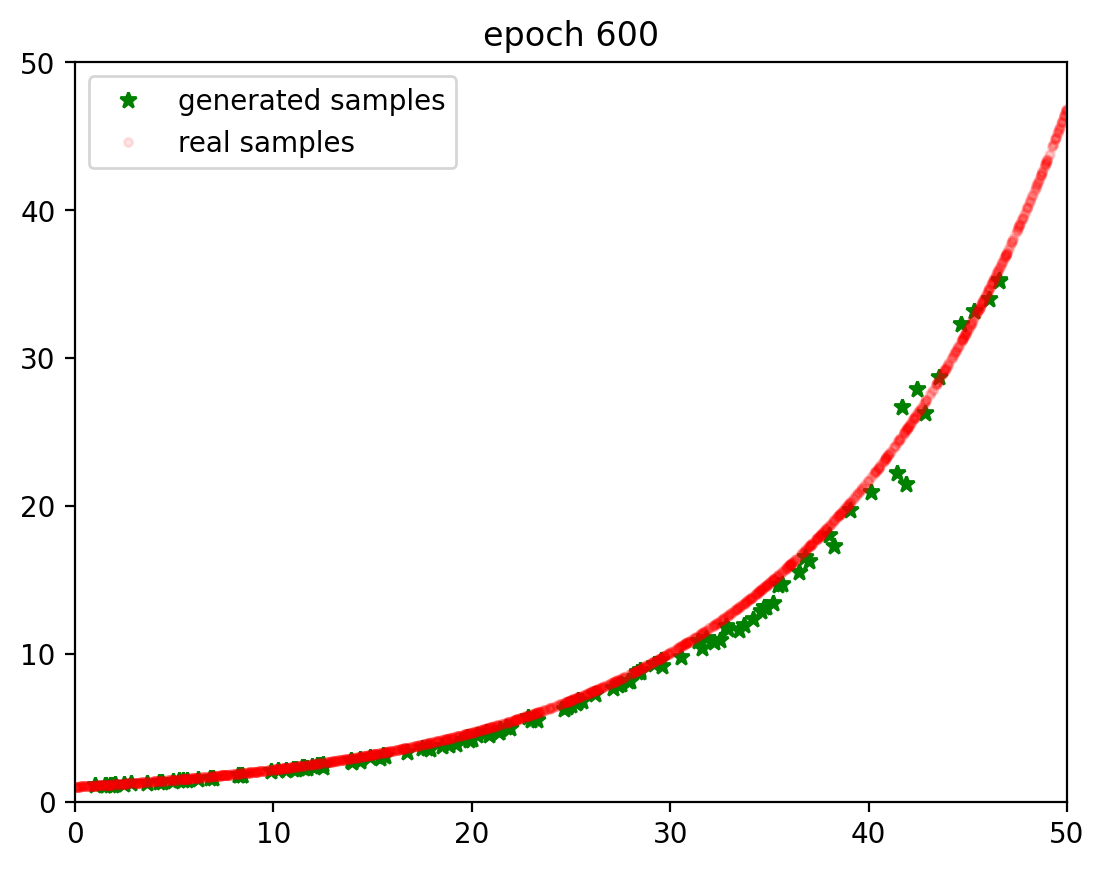

at epoch 625, G loss: 0.7508104960123698, D loss 1.4754199981689453


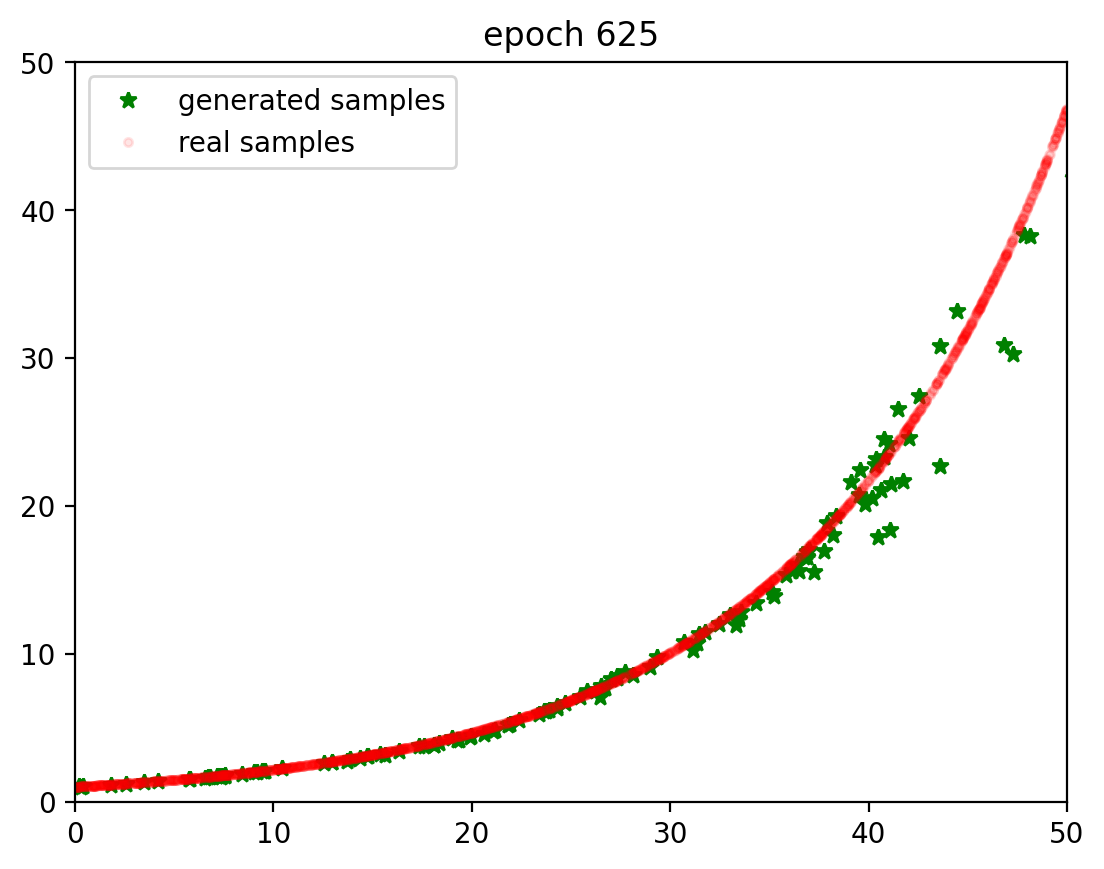

at epoch 650, G loss: 0.7520173390706381, D loss 1.4719486236572266


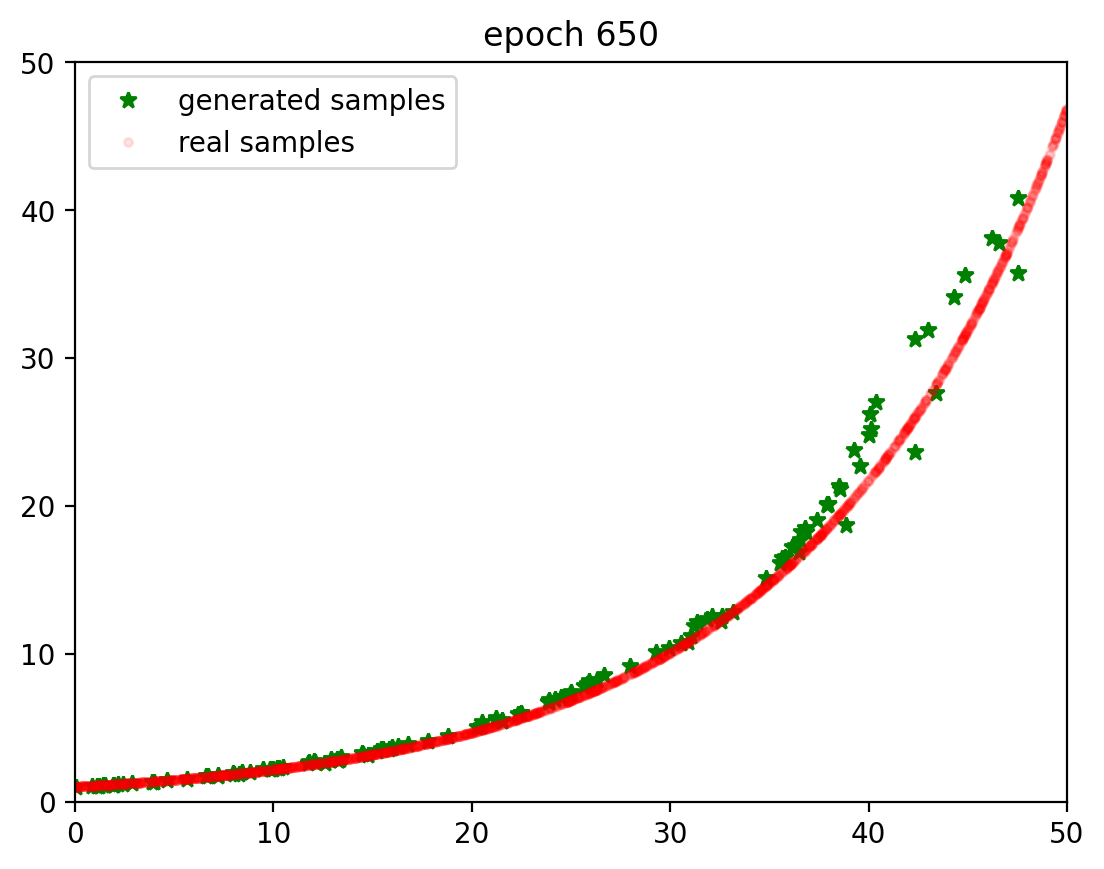

at epoch 675, G loss: 0.7507322947184245, D loss 1.473470942179362


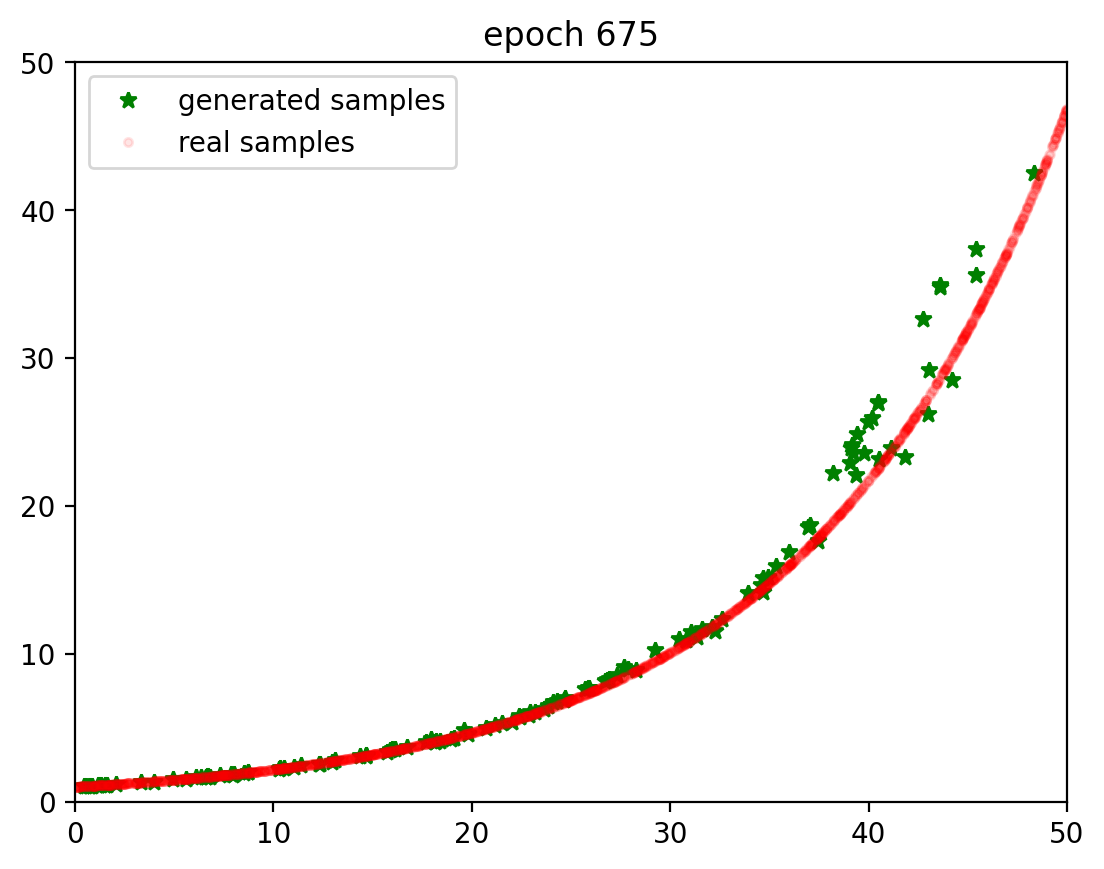

at epoch 700, G loss: 0.7567887624104818, D loss 1.4669319152832032


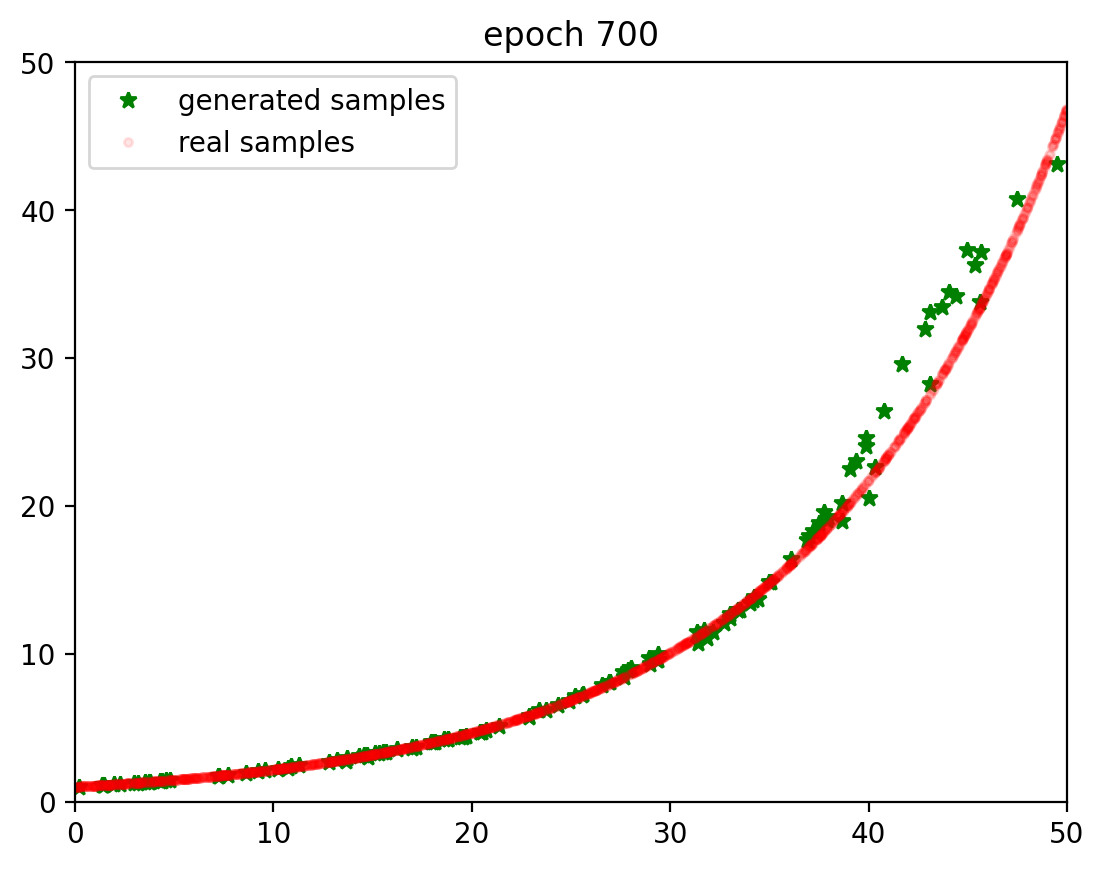

at epoch 725, G loss: 0.7594826380411784, D loss 1.4715965270996094


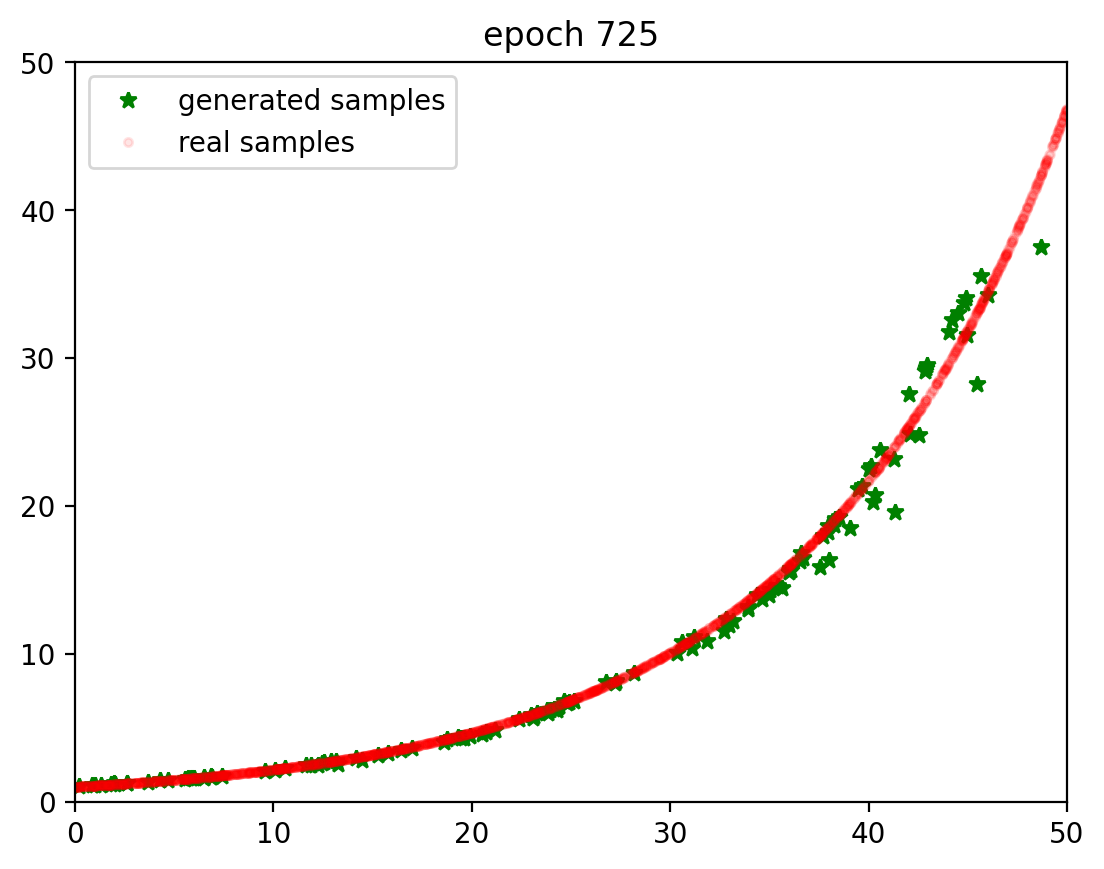

at epoch 750, G loss: 0.753587277730306, D loss 1.4715516408284506


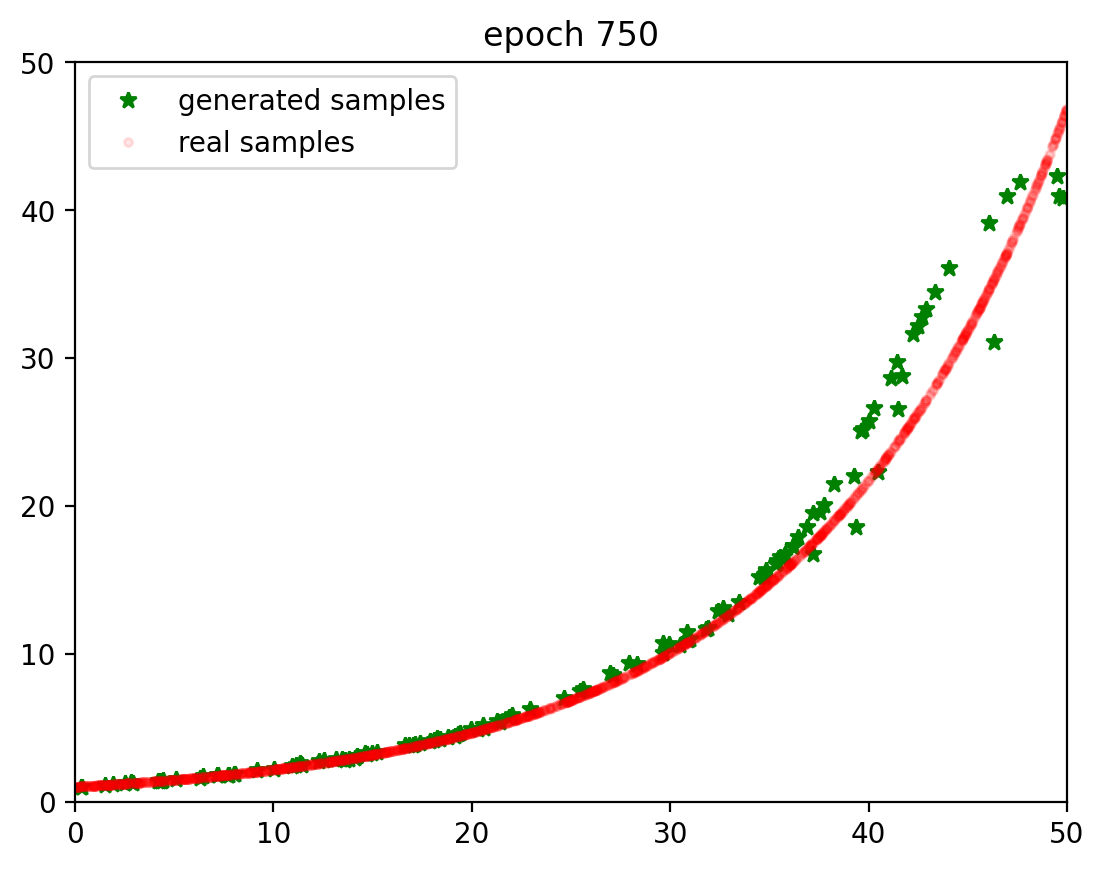

at epoch 775, G loss: 0.7634365717569987, D loss 1.4679288228352865


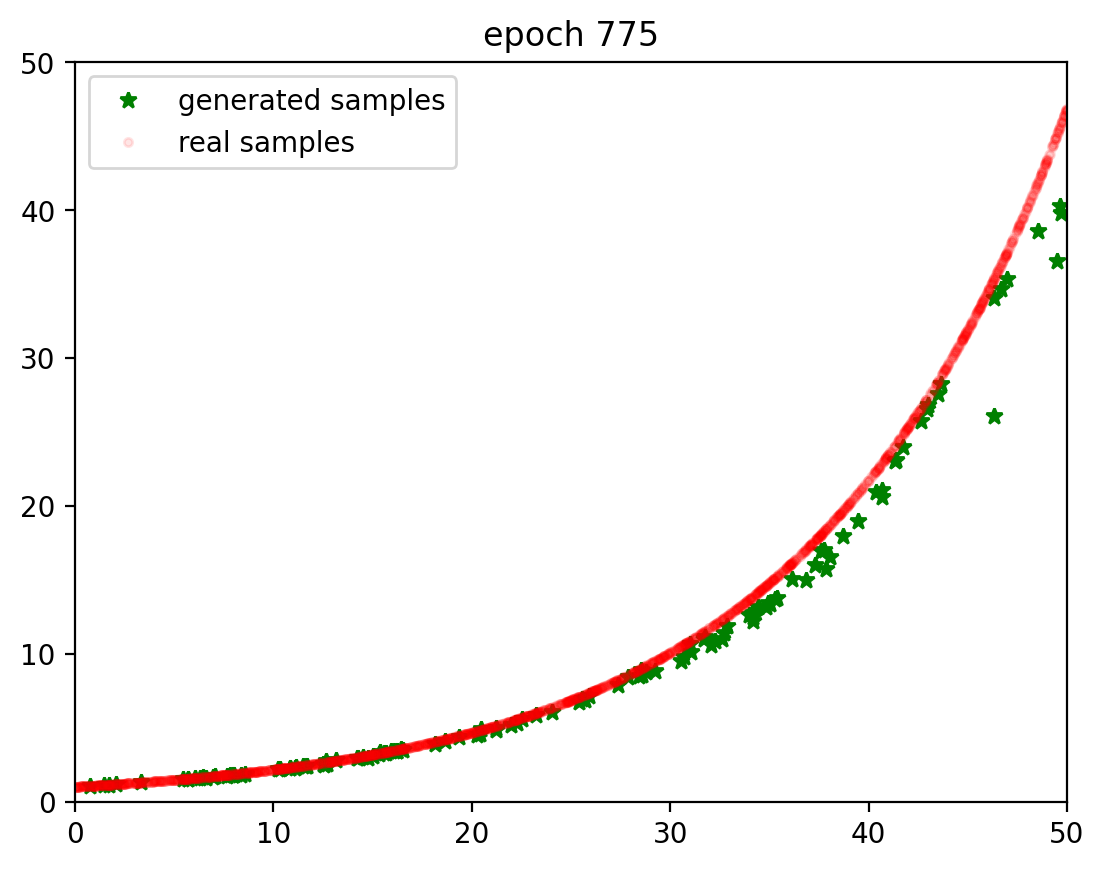

at epoch 800, G loss: 0.7604564666748047, D loss 1.4695290883382162


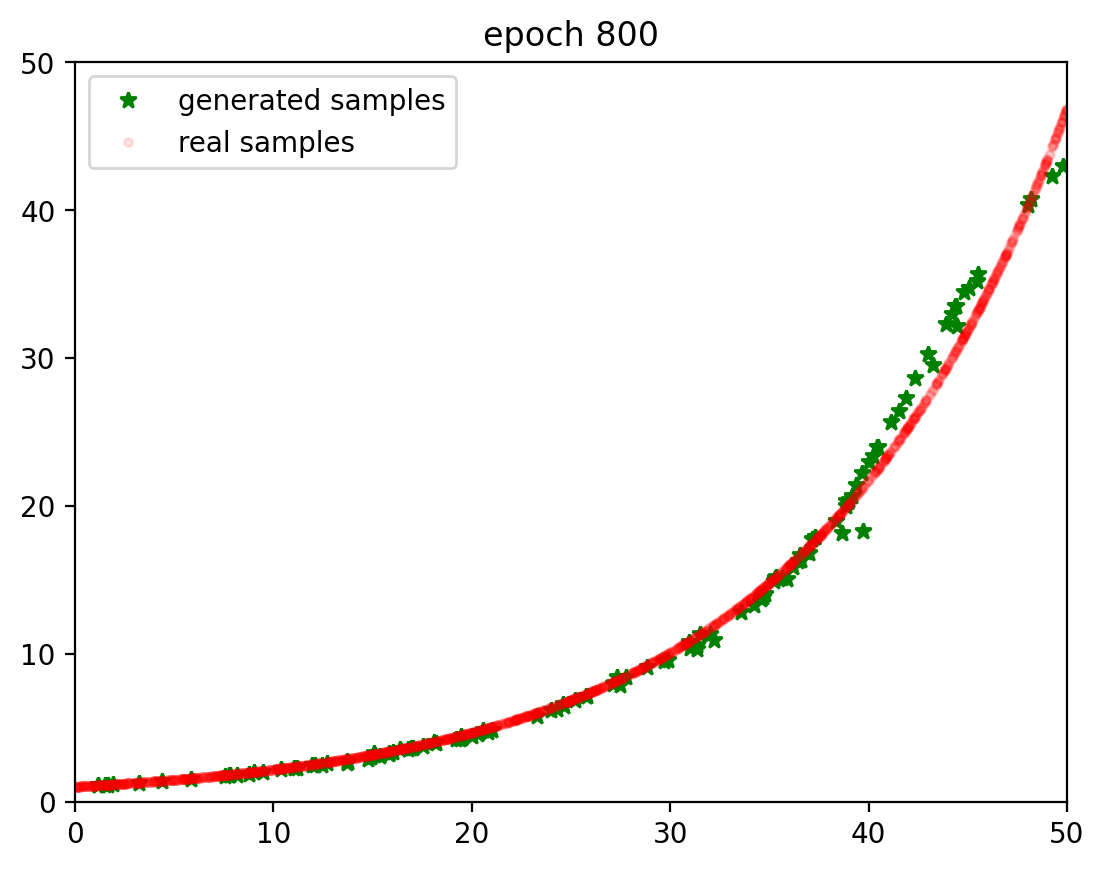

at epoch 825, G loss: 0.7572797139485677, D loss 1.4679622650146484


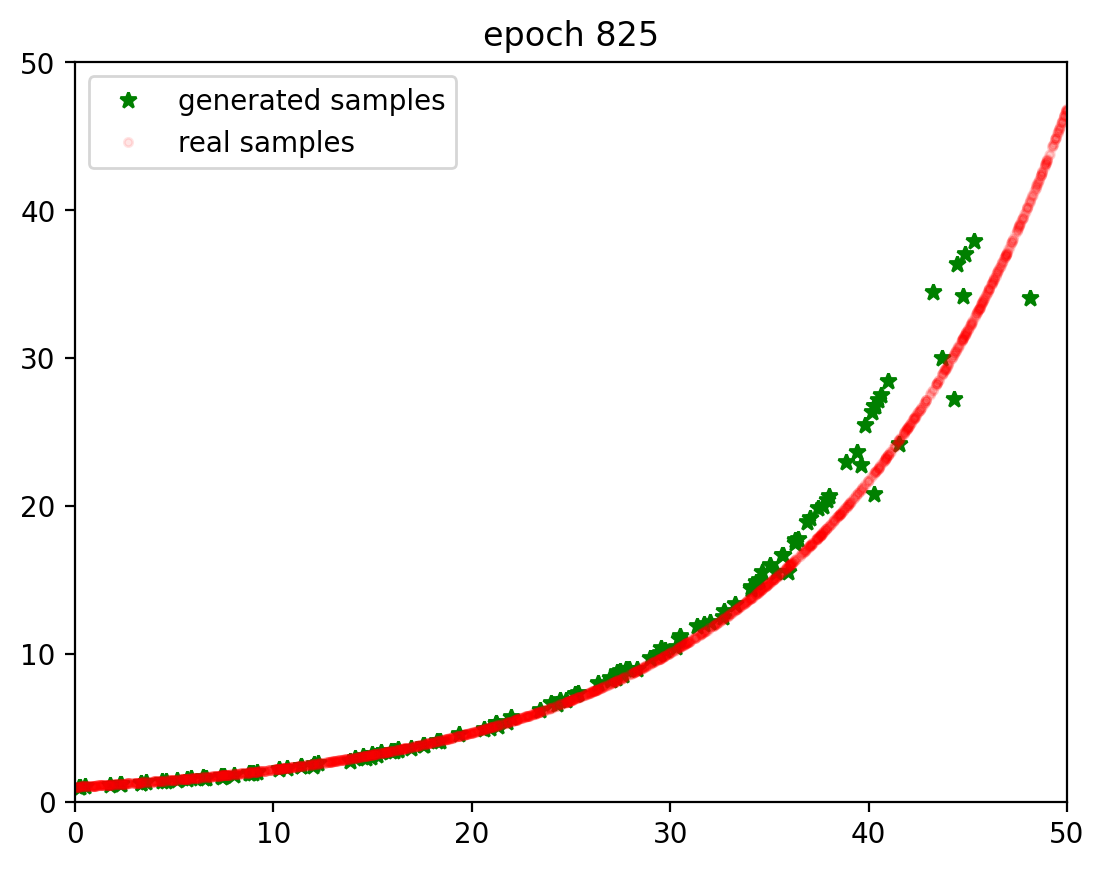

at epoch 850, G loss: 0.7563936233520507, D loss 1.46748046875


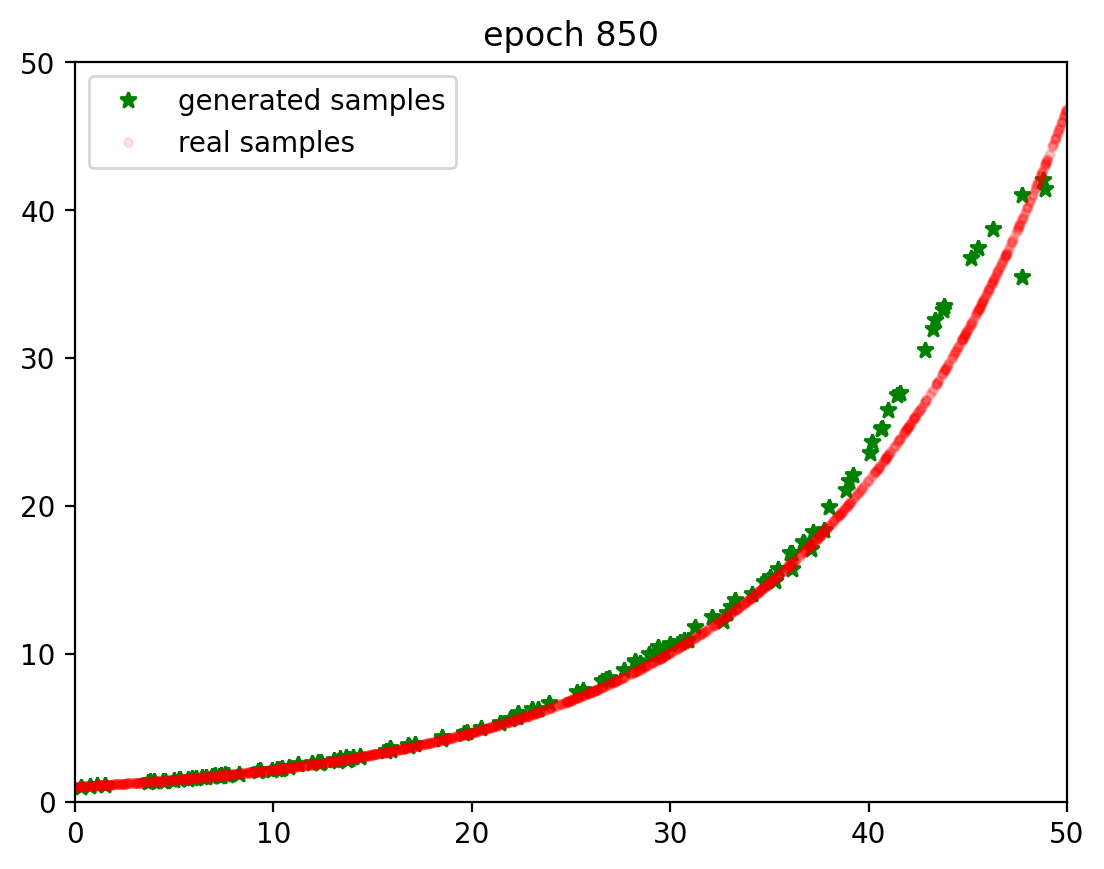

at epoch 875, G loss: 0.7466485977172852, D loss 1.4623241424560547


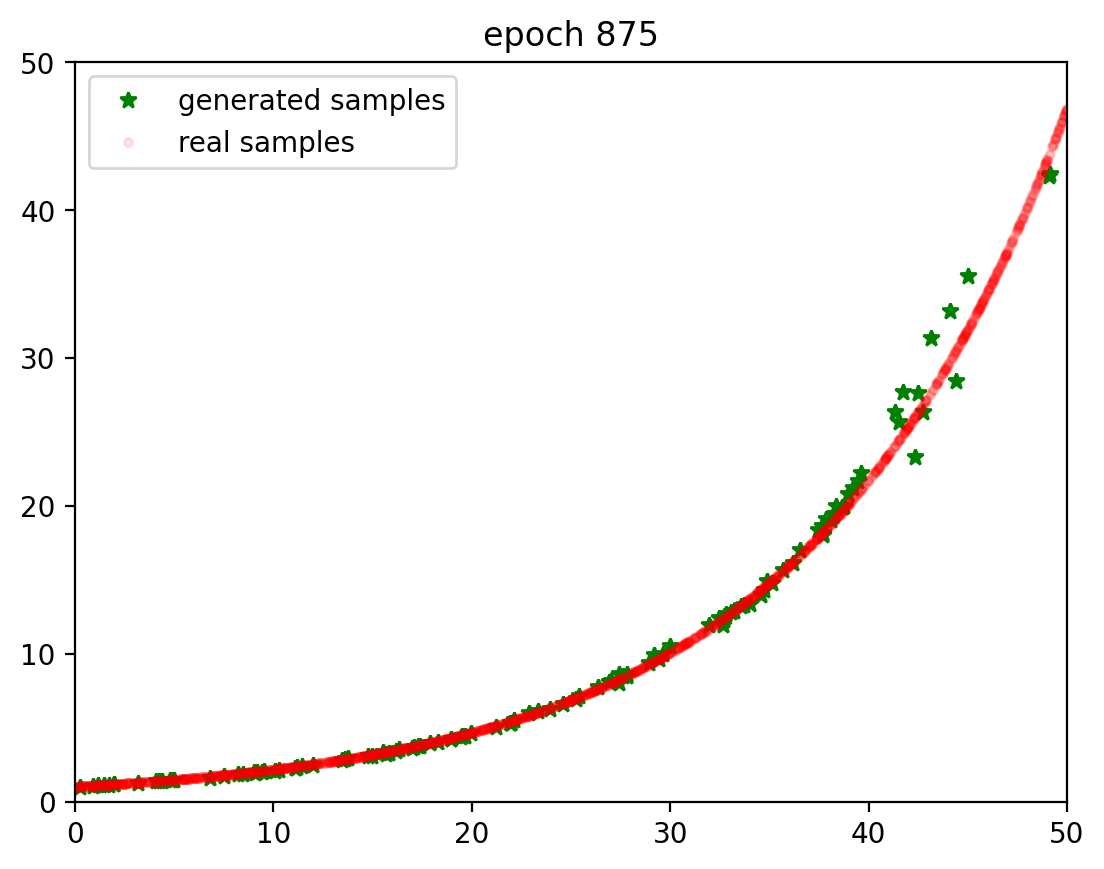

at epoch 900, G loss: 0.7725681304931641, D loss 1.4680118560791016


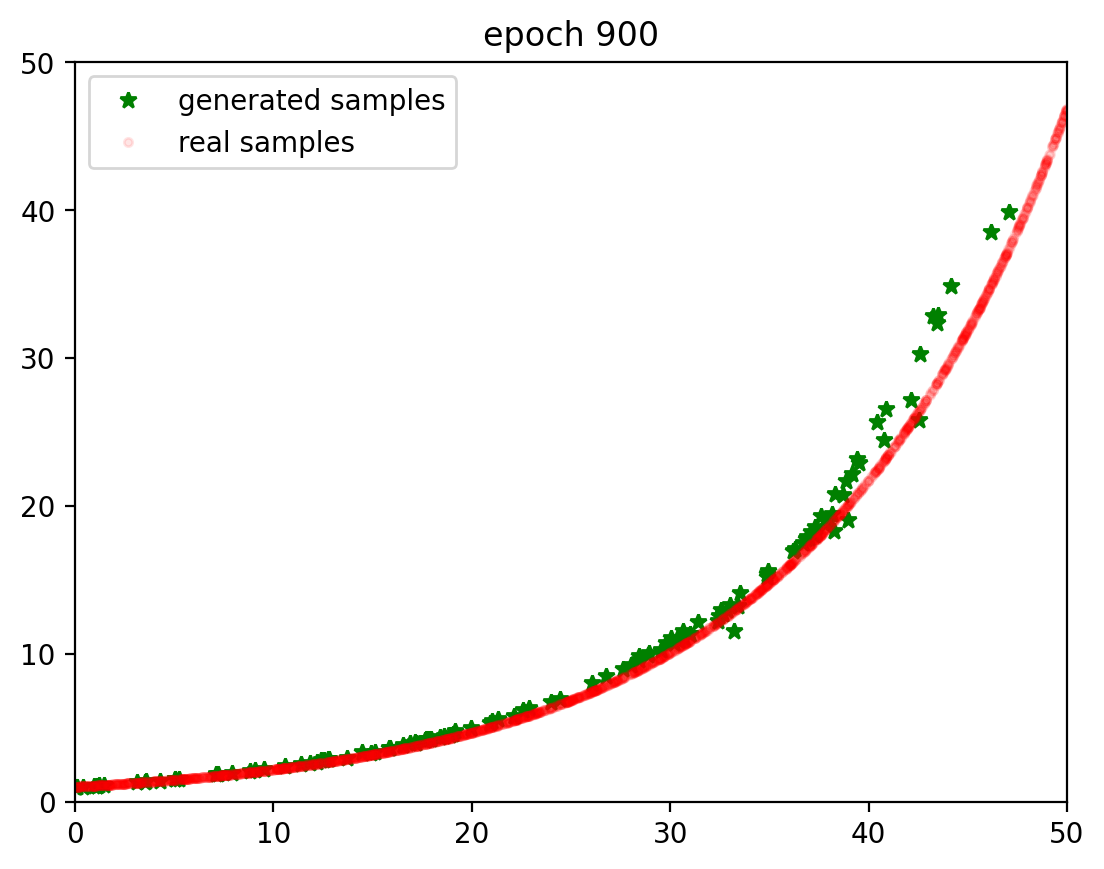

at epoch 925, G loss: 0.779255231221517, D loss 1.4689258575439452


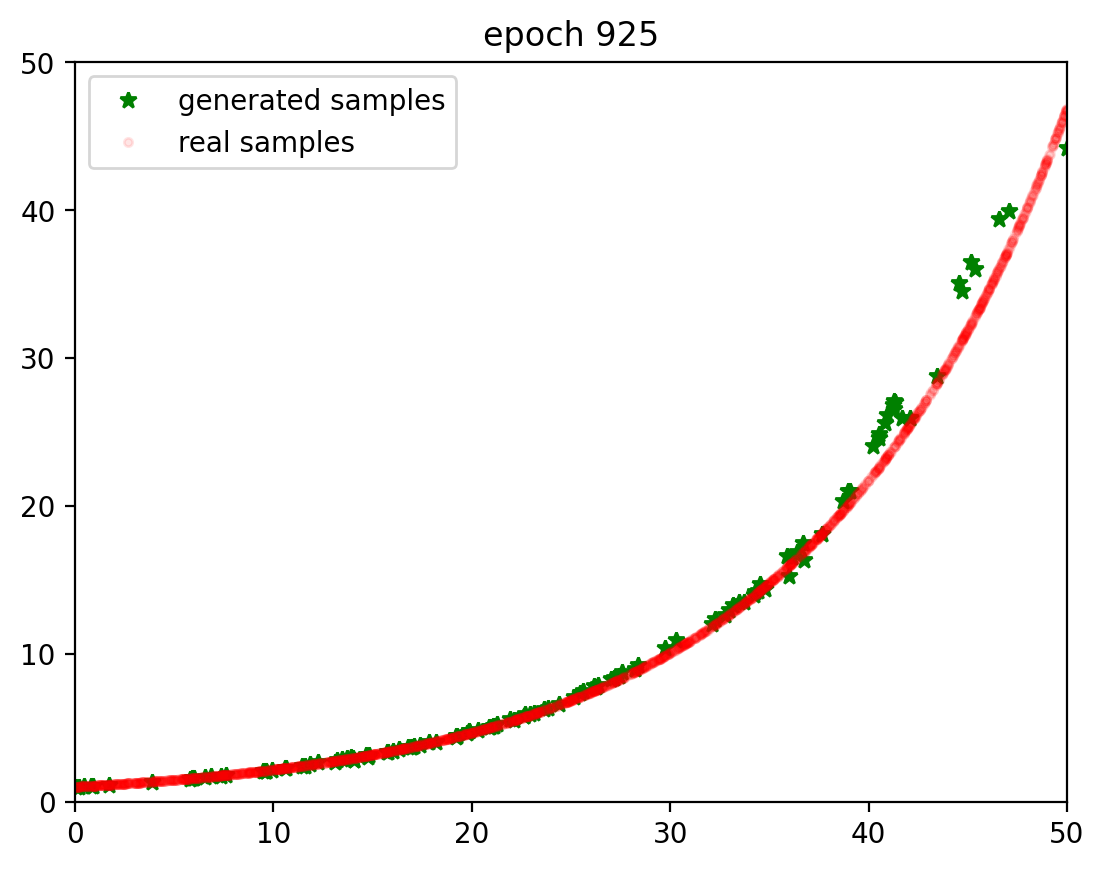

at epoch 950, G loss: 0.755518086751302, D loss 1.470422871907552


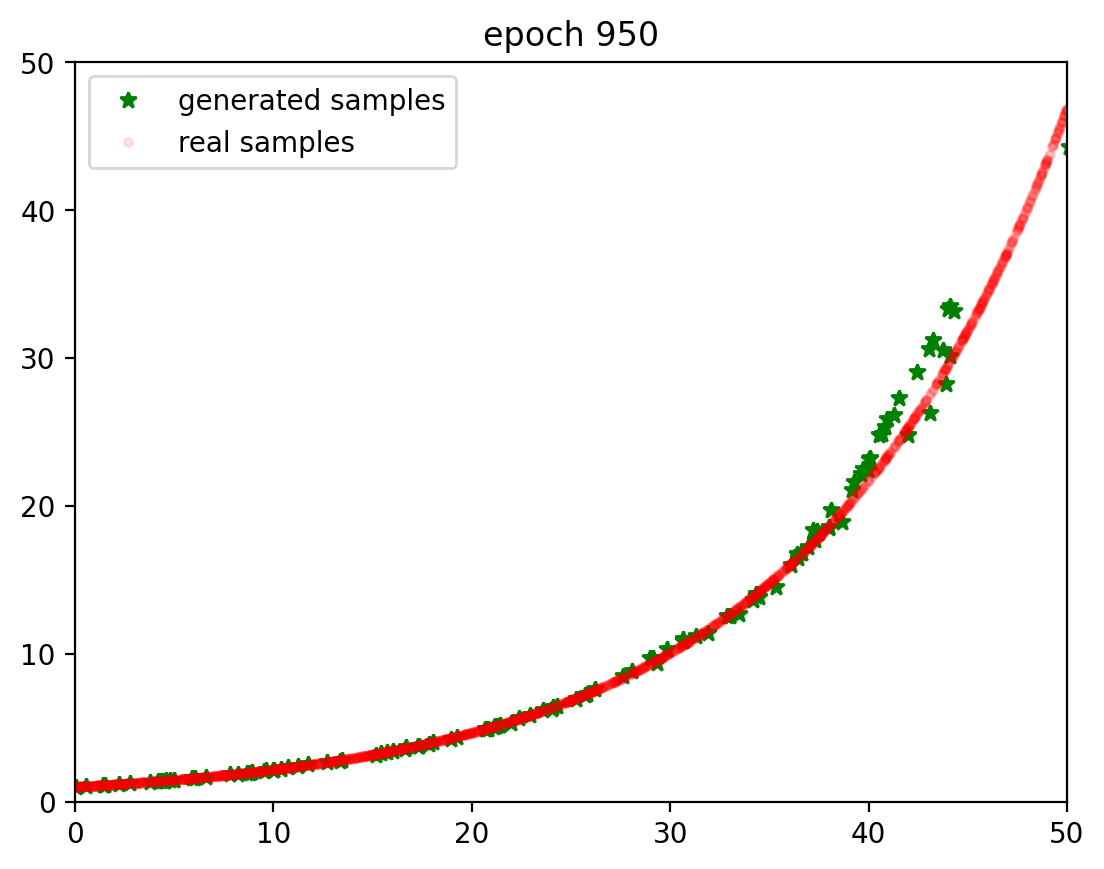

at epoch 975, G loss: 0.7610904057820638, D loss 1.46495730082194


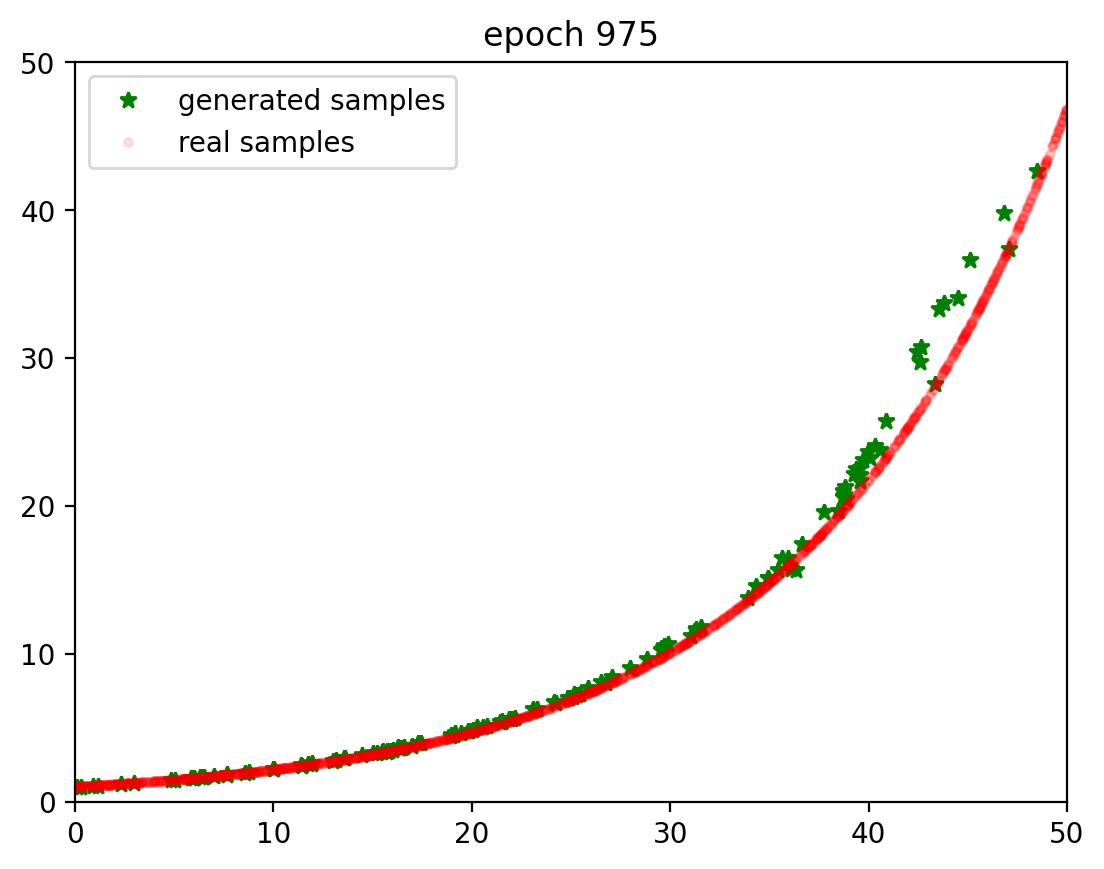

at epoch 1000, G loss: 0.7620030721028646, D loss 1.4579591115315755


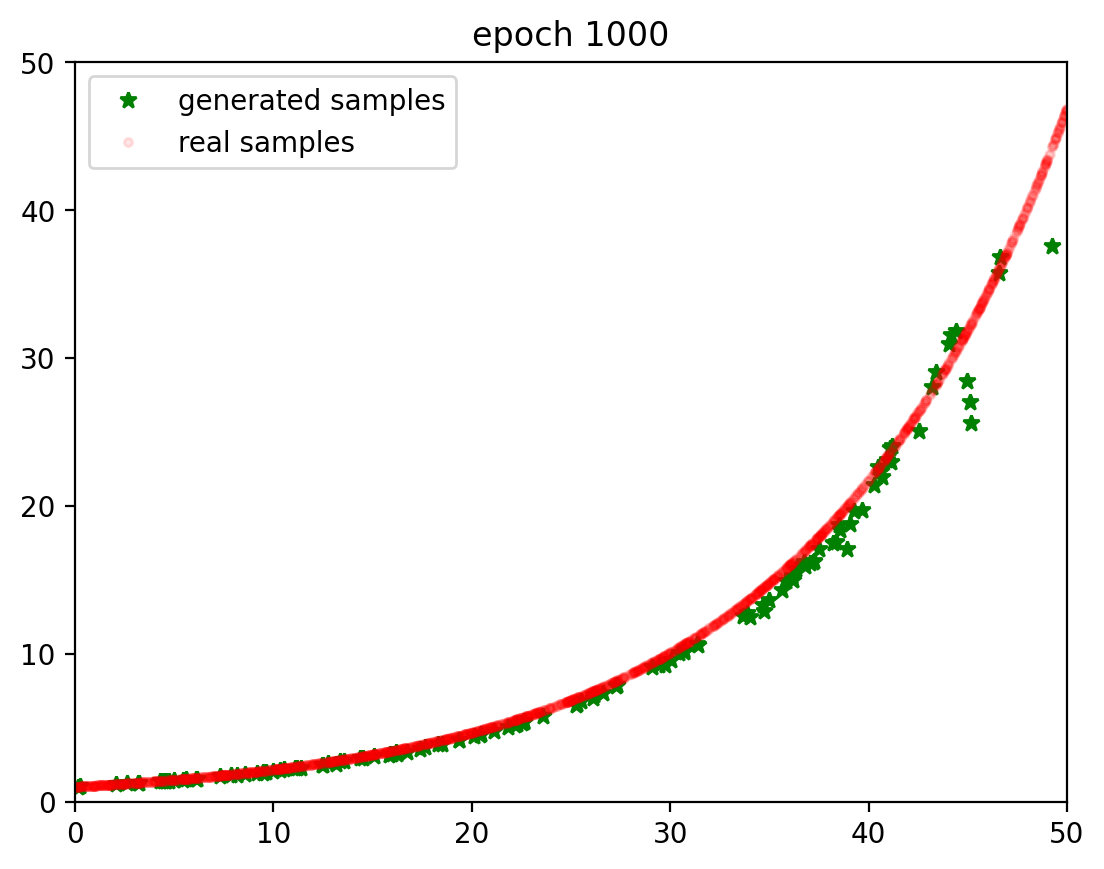

at epoch 1025, G loss: 0.8047121683756511, D loss 1.436670176188151


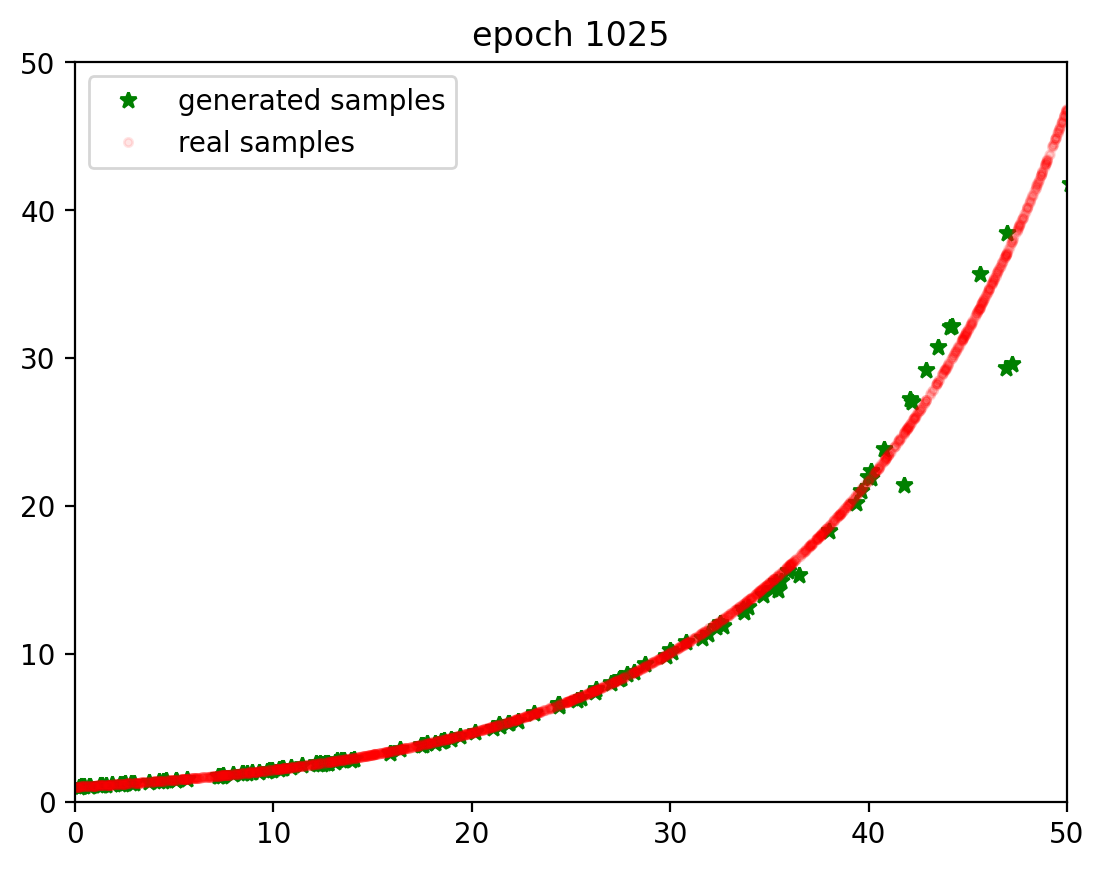

In [ ]:
for epoch in range(10000):    #A
    gloss=0
    dloss=0
    for n, real_samples in enumerate(train_loader):    #B
        loss_D=train_D_on_real(real_samples)
        dloss+=loss_D
        loss_D=train_D_on_fake()
        dloss+=loss_D
        loss_G,fake_samples=train_G()
        gloss+=loss_G
    test_epoch(epoch,gloss,dloss,n,fake_samples)    #C
    gdif=performance(fake_samples).item()
    if stopper.stop(gdif)==True:    #D
        break

Save and Use the Trained Model

In [ ]:
import os
os.makedirs("files", exist_ok=True)
scripted = torch.jit.script(G)
scripted.save('files/exponential.pt')

In [ ]:
new_G=torch.jit.load('files/exponential.pt',
                     map_location=device)
new_G.eval()

RecursiveScriptModule(
  original_name=Sequential
  (0): RecursiveScriptModule(original_name=Linear)
  (1): RecursiveScriptModule(original_name=ReLU)
  (2): RecursiveScriptModule(original_name=Linear)
  (3): RecursiveScriptModule(original_name=ReLU)
  (4): RecursiveScriptModule(original_name=Linear)
)

In [ ]:
noise=torch.randn((batch_size,2)).to(device)
new_data=new_G(noise)

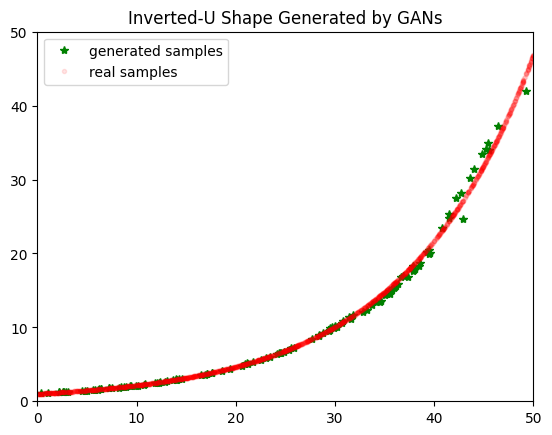

In [ ]:
fig=plt.figure(dpi=100)
plt.plot(new_data.detach().cpu().numpy()[:,0],
  new_data.detach().cpu().numpy()[:,1],"*",c="g",
        label="generated samples")    #A
plt.plot(train_data[:,0],train_data[:,1],".",c="r",
         alpha=0.1,label="real samples")    #B
plt.title("Inverted-U Shape Generated by GANs")
plt.xlim(0,50)
plt.ylim(0,50)
plt.legend()
plt.show()